<a href="https://colab.research.google.com/github/seahahn/seoul-apartment-price-ml/blob/main/seoul_apartment_price.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Creating a Machine Learning Model for Predicting High-Value Apartments in Seoul

- Presentation Video : https://youtu.be/BUYdITwkobY

## 1. Reason for Data Selection and Problem Definition

**Real estate transaction data in Seoul from 2017 to 2021 was chosen.**

- It was considered valuable to address the issue of Seoul apartment prices, a topic consistently mentioned across various media such as news and online articles, using machine learning.
- Therefore, the goal was to explore how apartment prices in 2021 and beyond would evolve based on the real estate transaction data from the recent 5 years.
- Additionally, with the current legal standard for luxury homes set at 900 million KRW (since 2008), it raised curiosity whether this threshold would be maintained in the ongoing situation of rising apartment prices.
- To investigate this, the trend of luxury home ratios was analyzed and predicted.
- Reference for luxury home standard: [Chosun article](https://www.chosun.com/economy/real_estate/2021/02/11/T3CAJH7P6VEWJDI4FNKGESJVDE/)
---
- Data from 2017 to 2020 was obtained from the Seoul Special City Real Estate Transaction Information as complete data.
- However, 2021 data was incomplete as it had not concluded.
- Instead, real transaction data from January 2021 to the end of last month, October 31, was acquired through the Ministry of Land, Infrastructure and Transport's real estate transaction disclosure system.
---
- Price prediction is a regression problem, and luxury home classification is a classification problem.
- Therefore, Ridge Regression was used for price prediction, Logistic Regression for classification prediction, and for both predictions, decision trees, random forests, and gradient boosting models were employed.
- After comparing their performances, the final model was determined.

In [ ]:
# from google.colab import drive
# drive.mount('/content/gdrive')

In [ ]:
# ! pip install category_encoders
# ! pip install eli5
# ! pip install shap
# ! pip install pdpbox

In [ ]:
from joblib import dump, load

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from category_encoders import TargetEncoder, OrdinalEncoder, LeaveOneOutEncoder
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.compose import TransformedTargetRegressor

from sklearn.linear_model import RidgeCV, LogisticRegression
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from xgboost import XGBRegressor, XGBClassifier

from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_absolute_error, r2_score, f1_score, roc_curve, classification_report, plot_confusion_matrix, roc_auc_score
from scipy.stats import randint, uniform

import eli5
from eli5.sklearn import PermutationImportance
from pdpbox import pdp
from pdpbox.pdp import pdp_isolate, pdp_plot, pdp_interact, pdp_interact_plot
import shap

In [ ]:
# Data Source:
# 1. Seoul Open Data Plaza - Seoul Special City Real Estate Transaction Information (2017~2020)
# https://data.seoul.go.kr/dataList/OA-15548/S/1/datasetView.do
# 2. Ministry of Land, Infrastructure and Transport Real Estate Transaction Disclosure System (2021)
# http://rtdown.molit.go.kr/

data2020 = pd.read_csv('https://docs.google.com/uc?export=download&id=1WyeDe2Ry4ohJobcbnQJXHxFEAtcg-CC_', encoding='cp949')
data2019 = pd.read_csv('https://docs.google.com/uc?export=download&id=1tlNazFOkcYJVeiDlLM5ZtnVUGP3PTqt3', encoding='cp949')
data2018 = pd.read_csv('https://docs.google.com/uc?export=download&id=1bYkV3RBfrPftGoCdNw0vKZiNoiVr6itJ', encoding='cp949')
data2017 = pd.read_csv('https://docs.google.com/uc?export=download&id=1mbtBM_8_wYNEICXp_TdLNrV2yBLfAGEe', encoding='cp949')

data2021 = pd.read_csv('https://docs.google.com/uc?export=download&id=1ooZBZfgqUgxlKhefrWwaFGvaP1-zu3SA', encoding='cp949')

addr_code = pd.read_csv('https://docs.google.com/uc?export=download&id=1NyrxzBSUOoCPBcIxKfQtZAMiL9hqaLe9', encoding='cp949')

# Predicting Luxury Homes in Seoul Real Estate (Apartments)
# Testing the Prediction of Luxury Homes in Seoul Real Estate (Apartments) Based on 2017-2020 Transaction Data
# 1) Price Prediction - Excluded (due to inadequate model performance)
# 2) Classification of Luxury Homes (Above 900 million KRW) and Non-Luxury Homes

## 2. Hypotheses, Evaluation Metrics, and Baseline Selection Using the Data

1) Targets
  - Regression Problem: Transaction Amount
    - Objective is to understand and predict the trends in Seoul real estate prices
  - Classification Problem: Luxury Home Status (Newly Created Feature)
    - Aim is to observe and predict the changing patterns in the proportion of luxury homes
    - Purpose is to evaluate whether the current standard of 900 million KRW for luxury homes remains appropriate

2) Hypotheses (Transaction Amount / Luxury Home Status)
  1. The larger the floor area, the higher the transaction amount. / The probability of it being a luxury home is higher.
  2. The higher the floor information (higher floor), the higher the transaction amount. / The probability of it being a luxury home is higher.
  3. The more recent the construction year, the higher the transaction amount. / The probability of it being a luxury home is higher.
  4. The average and median transaction amounts will differ by district (locality). / The proportion of luxury homes will differ.
  5. The annual price increase rate of transaction amounts will differ by district (locality). / The rate of change in the proportion of luxury homes will differ.

3) Baseline Model
  - Regression Problem: MAE and R Squared for the average and median values of 'Transaction Amount' from 2017 to 2021.
  - Classification Problem: Proportion of luxury home classification from 2017 to 2021.

4) Evaluation Metrics
  - For Regression Problem:
    - MAE: Rough measure of how much the predictions deviate from actual values
    - R Squared: Overall assessment of predictive performance.
  - For Classification Problem:
    - F1 Score: Overall measure of prediction performance.
    - ROC-AUC Score: Enhances prediction performance through threshold setting.
    - Confusion Matrix: Accuracy, precision, and recall of predictions.


## 3. EDA, Data Preprocessing, and Baseline Visualization

### 1) EDA (Exploratory Data Analysis)

In [ ]:
# 2017 ~ 2020
past = pd.concat([data2020, data2019, data2018, data2017], axis=0)
print(past.shape)
display(pd.DataFrame([past.dtypes, past.isna().sum()], index=['dtypes', 'isna']))
past.head()

(659636, 20)


,실거래가아이디,지번코드,시군구코드,자치구명,법정동코드,법정동명,신고년도,업무구분코드,업무구분,물건번호,대지권면적,건물면적,관리구분코드,층정보,건물주용도코드,건물주용도,물건금액,건축년도,건물명,"실거래가아이디"""
dtypes,object,object,int64,object,int64,object,int64,int64,object,int64,float64,float64,object,float64,int64,object,int64,float64,object,object
isna,130272,0,0,0,0,0,0,0,0,0,282052,0,0,52490,0,0,0,1220,52490,529364


,실거래가아이디,지번코드,시군구코드,자치구명,법정동코드,법정동명,신고년도,업무구분코드,업무구분,물건번호,대지권면적,건물면적,관리구분코드,층정보,건물주용도코드,건물주용도,물건금액,건축년도,건물명,"실거래가아이디"""
0,11290-2020-4-0000066-1,1129013800101440024,11290,성북구,1129013800,장위동,2020,4,신고,1,0.0,59.92,2,5.0,2001,아파트,749000000,0.0,래미안 장위포레카운티,NaN
1,11290-2020-4-0000628-1,1129013400105080016,11290,성북구,1129013400,길음동,2020,4,신고,1,0.0,84.77,2,18.0,2001,아파트,1200000000,0.0,롯데캐슬 클라시아,NaN
2,11530-2020-4-0014284-1,1153010200107400029,11530,구로구,1153010200,구로동,2020,4,신고,1,NaN,36.90,0,1.0,2001,아파트,105000000,1994.0,궁전아트빌라,NaN
3,11170-2020-4-0005040-1,1117011500101930000,11170,용산구,1117011500,산천동,2020,4,신고,1,NaN,59.55,0,2.0,2001,아파트,830000000,2001.0,리버힐삼성,NaN
4,11170-2020-4-0001553-1,1117012900101930003,11170,용산구,1117012900,이촌동,2020,4,신고,1,NaN,64.43,0,5.0,2001,아파트,735000000,1971.0,강변,NaN


In [ ]:
# 2021
print(data2021.shape)
display(pd.DataFrame([data2021.dtypes, data2021.isna().sum()], index=['dtypes', 'isna']))
data2021.head()

(40122, 15)


,시군구,번지,본번,부번,단지명,전용면적(㎡),계약년월,계약일,거래금액(만원),층,건축년도,도로명,해제사유발생일,거래유형,중개사소재지
dtypes,object,object,float64,float64,object,float64,int64,int64,object,int64,int64,object,float64,object,object
isna,0,12,5,5,0,0,0,0,0,0,0,0,39106,0,0


,시군구,번지,본번,부번,단지명,전용면적(㎡),계약년월,계약일,거래금액(만원),층,건축년도,도로명,해제사유발생일,거래유형,중개사소재지
0,서울특별시 강남구 개포동,655-2,655.0,2.0,개포2차현대아파트(220),77.75,202104,15,"174,000",9,1988,언주로 103,NaN,-,-
1,서울특별시 강남구 개포동,658-1,658.0,1.0,개포6차우성아파트1동~8동,79.97,202105,15,"195,000",5,1987,언주로 3,NaN,-,-
2,서울특별시 강남구 개포동,658-1,658.0,1.0,개포6차우성아파트1동~8동,79.97,202108,11,"200,000",3,1987,언주로 3,NaN,-,-
3,서울특별시 강남구 개포동,658-1,658.0,1.0,개포6차우성아파트1동~8동,79.97,202109,2,"220,000",2,1987,언주로 3,NaN,-,-
4,서울특별시 강남구 개포동,1282,1282.0,0.0,개포래미안포레스트,74.66,202101,17,"245,000",7,2020,개포로 264,NaN,-,-


### 2) Aligning Formats of Data from 2017 to 2020 and 2021

The sources of data from 2017 to 2020 and 2021 differ, resulting in different formats.
These need to be aligned with the format of the data from 2017 to 2020.

#### 2-1) Removing Unnecessary Columns and Data

Starting with removing unnecessary columns from both the data from 2017 to 2020 and the data from 2021.

Additionally, non-apartment data will be excluded.

##### 2-1-1) Removing Unnecessary Columns and Data from 2017 to 2020 Data

In [ ]:
# Removing Unnecessary Columns from 2017 to 2020 Data

# As the '대지권면적' has mostly missing values, it is removed
# It represents an area that includes aspects other than the actual residential area, making it unnecessary
# Reference: https://m.blog.naver.com/PostView.naver?isHttpsRedirect=true&blogId=ctrfindit&logNo=221272287733
past = past.drop('대지권면적', axis=1)

# There is a suspicion that the building name may influence the price due to factors like brand value
# However, at the moment, we do not have a clear method of handling this, so the '건물명' column is removed
past = past.drop('건물명', axis=1)

# '실거래가아이디' is a unique identifier for the transaction itself and is not relevant to the price, so the column is removed
past = past.drop('실거래가아이디', axis=1)
past = past.drop('실거래가아이디"', axis=1)

# All entries in '업무구분' are '신고' (reporting), and '업무구분코드' is always '4' corresponding to reporting
# Considering these factors, the column is deemed unnecessary and is removed
past = past.drop(['업무구분', '업무구분코드'], axis=1)

# '물건번호' represents a unique number attached to each item in an auction
# For example, if there is one item in an incident, the '물건번호' is 1
# As it is a kind of unique number and is not relevant to the price, the column is removed
# Reference: https://m.blog.naver.com/maestron1/221534254422
past = past.drop('물건번호', axis=1)

# '관리구분코드' is presumed to be used internally within public institutions
# Detailed information could not be verified
# Judging by the name, it seems unrelated to the item price, so the column is removed
past = past.drop('관리구분코드', axis=1)

In [ ]:
# Removing data where '건물주용도' is not an apartment
past = past.loc[past['건물주용도'] == '아파트', :]

In [ ]:
past['건물주용도'].unique()

array(['아파트'], dtype=object)

In [ ]:
# Since '건물주용도' only contains apartments, the '건물주용도' and '건물주용도코드' columns are removed
past = past.drop(['건물주용도', '건물주용도코드'], axis=1)

In [ ]:
past['건축년도'].unique()
# There are data with '건축년도' as NaN or 0

array([   0., 1994., 2001., 1971., 1982., 2002., 1998., 2000., 2018.,
       1997., 2003., 2017., 1996., 2013., 2016., 2019., 1977., 1989.,
       2006., 1999., 1986., 2012., 1990., 2004., 2007., 2005., 1992.,
       1983., 2014., 1987., 1995., 2011., 1984., 1991., 2010., 2009.,
       2015., 2008., 1978., 1985., 2020., 1972., 1993., 1981., 1976.,
       1969., 1988., 1979., 1975., 1974., 1961., 1980., 1973., 1970.,
       1966., 1968., 1965., 1967.])

In [ ]:
print(past.shape)
len(past[(past['건축년도'] == 0) | (past['건축년도'].isna())])

(358741, 10)


14732

In [ ]:
# As it constitutes around 5% of the total data, it is r
past = past[(past['건축년도'] != 0) & ~(past['건축년도'].isna())]
len(past[(past['건축년도'] == 0) | (past['건축년도'].isna())])

0

In [ ]:
print(past.shape)
display(pd.DataFrame([past.dtypes, past.isna().sum()], index=['dtypes', 'isna']))
past.head()

(344009, 10)


,지번코드,시군구코드,자치구명,법정동코드,법정동명,신고년도,건물면적,층정보,물건금액,건축년도
dtypes,object,int64,object,int64,object,int64,float64,float64,int64,float64
isna,0,0,0,0,0,0,0,0,0,0


,지번코드,시군구코드,자치구명,법정동코드,법정동명,신고년도,건물면적,층정보,물건금액,건축년도
2,1153010200107400029,11530,구로구,1153010200,구로동,2020,36.90,1.0,105000000,1994.0
3,1117011500101930000,11170,용산구,1117011500,산천동,2020,59.55,2.0,830000000,2001.0
4,1117012900101930003,11170,용산구,1117012900,이촌동,2020,64.43,5.0,735000000,1971.0
5,1117013000100220002,11170,용산구,1117013000,이태원동,2020,105.75,9.0,1430000000,1982.0
7,1117010100102440088,11170,용산구,1117010100,후암동,2020,150.08,4.0,875000000,2002.0


##### 2-1-2) 2021 데이터 불필요한 컬럼 및 데이터 제거

In [ ]:
# There is a suspicion that the '단지명' may influence the price due to factors like brand value
# However, at the moment, we do not have a clear method of handling this, so the '단지명' column is removed
data2021 = data2021.drop('단지명', axis=1)

# '계약년월' and '계약일' are replaced with the '신고년도' column in the 'past' dataframe in the same format
# '계약일' column is removed, and the '계약년월' column name is changed
# The data values in the '계약년월' column are replaced with the value '2021' for the entire column
# Other column names that do not match with the 'past' dataframe are aligned
data2021 = data2021.drop('계약일', axis=1)
data2021['계약년월'] = 2021
data2021.rename(columns={'계약년월':'신고년도', '전용면적(㎡)':'건물면적', '층':'층정보', '거래금액(만원)':'물건금액'}, inplace=True)

# As the format will be based on the '지번' address like the 'past' dataframe, the '도로명' column is removed
data2021 = data2021.drop('도로명', axis=1)

# Columns like '해제사유발생일', '거래유형', '중개사소재지' are considered irrelevant to real estate prices and are removed
data2021 = data2021.drop(['해제사유발생일', '거래유형', '중개사소재지'], axis=1

In [ ]:
print(data2021.shape)
display(pd.DataFrame([data2021.dtypes, data2021.isna().sum()], index=['dtypes', 'isna']))
data2021.head()

(40122, 9)


,시군구,번지,본번,부번,건물면적,신고년도,물건금액,층정보,건축년도
dtypes,object,object,float64,float64,float64,int64,object,int64,int64
isna,0,12,5,5,0,0,0,0,0


,시군구,번지,본번,부번,건물면적,신고년도,물건금액,층정보,건축년도
0,서울특별시 강남구 개포동,655-2,655.0,2.0,77.75,2021,"174,000",9,1988
1,서울특별시 강남구 개포동,658-1,658.0,1.0,79.97,2021,"195,000",5,1987
2,서울특별시 강남구 개포동,658-1,658.0,1.0,79.97,2021,"200,000",3,1987
3,서울특별시 강남구 개포동,658-1,658.0,1.0,79.97,2021,"220,000",2,1987
4,서울특별시 강남구 개포동,1282,1282.0,0.0,74.66,2021,"245,000",7,2020


#### 2-2) Aligning Column Names and Data Formats

- While the content is the same, there may be cases where column names differ, columns are missing, or data meanings are the same but the representation is different.
- Inconsistent formats are aligned according to the 'past' dataframe, which serves as the reference.

- Since the 'past' dataframe is the reference, the 2021 data is processed accordingly.

In [ ]:
# Since the missing values are a minority, they are removed
data2021 = data2021.dropna(axis=0)

In [ ]:
print(data2021.shape)
display(pd.DataFrame([data2021.dtypes, data2021.isna().sum()], index=['dtypes', 'isna']))
data2021.head()

(40110, 9)


,시군구,번지,본번,부번,건물면적,신고년도,물건금액,층정보,건축년도
dtypes,object,object,float64,float64,float64,int64,object,int64,int64
isna,0,0,0,0,0,0,0,0,0


,시군구,번지,본번,부번,건물면적,신고년도,물건금액,층정보,건축년도
0,서울특별시 강남구 개포동,655-2,655.0,2.0,77.75,2021,"174,000",9,1988
1,서울특별시 강남구 개포동,658-1,658.0,1.0,79.97,2021,"195,000",5,1987
2,서울특별시 강남구 개포동,658-1,658.0,1.0,79.97,2021,"200,000",3,1987
3,서울특별시 강남구 개포동,658-1,658.0,1.0,79.97,2021,"220,000",2,1987
4,서울특별시 강남구 개포동,1282,1282.0,0.0,74.66,2021,"245,000",7,2020


In [ ]:
# To create the '지번코드', the '시군구', '본번', and '부번' columns are used along with the legal code data
addr_code.head()

,법정동코드,법정동명
0,1111000000,종로구
1,1111010100,종로구 청운동
2,1111010200,종로구 신교동
3,1111010300,종로구 궁정동
4,1111010400,종로구 효자동


In [ ]:
data2021['자치구명'] = data2021['시군구'].str.split(' ').str[1]
data2021['법정동명'] = data2021['시군구'].str.split(' ').str[2]
data2021['자치구법정동'] = data2021['자치구명'] + ' ' + data2021['법정동명']

In [ ]:
# A dictionary is created for faster calculations, using the pairs of '법정동명' and '법정동코드'
addr_map = dict([(addr_str,code) for code, addr_str in zip(addr_code['법정동코드'], addr_code['법정동명'])])

def findAddrCode(input):
  return addr_map[input]

In [ ]:
# Obtaining the legal code through the district and legal name
# String conversion (for creating the '지번코드')
data2021['법정동코드'] = data2021['자치구법정동'].apply(findAddrCode).astype(str)

In [ ]:
# To create the '지번코드' column, '필지구분(1)' + '본번(4)' + '부번(4)' needs to be appended after the legal code
# First, convert the '본번' and '부번' columns to integers, remove decimals, and convert to strings (for creating the '지번코드')
data2021[['본번', '부번']] = data2021[['본번', '부번']].astype(int).astype(str)

In [ ]:
# To create the '필지구분' column, find data in the '번지' column that contains "산"
# If "산" is present, assign 2; otherwise, assign 1
# Convert to string (for the purpose of creating the '지번코드')
data2021['필지구분'] = data2021['번지'].apply(lambda x: 2 if '산' in x else 1).astype(str)

In [ ]:
# Using 4 digits each for '본번' and '부번', fill numbers from the back, replacing insufficient places with 0
data2021['본번'] = data2021['본번'].apply(lambda x: x.zfill(4))
data2021['부번'] = data2021['부번'].apply(lambda x: x.zfill(4))

In [ ]:
# Create the '지번코드' column (Legal Dong Code(10) + Land Type(1) + Main Number(4) + Sub Number(4) = 19 digits)
data2021['지번코드'] = data2021['법정동코드'] + data2021['필지구분'] + data2021['본번'] + data2021['부번']

In [ ]:
# Create the '시군구코드' column
data2021['시군구코드'] = data2021['법정동코드'].str.slice(stop=5)

In [ ]:
# Align the format of the transaction amount
def moneyFormMatch(input):
  return int(input.replace(',', ''))*10000

data2021['물건금액'] = data2021['물건금액'].apply(moneyFormMatch)

In [ ]:
# Remove unnecessary columns to match the format with the 'past' data
data2021 = data2021.drop(['시군구', '번지', '본번', '부번', '자치구법정동', '필지구분'], axis=1)

In [ ]:
# Align the column order
data2021 = data2021[['지번코드', '시군구코드', '자치구명', '법정동코드', '법정동명', '신고년도', '건물면적', '층정보', '물건금액', '건축년도']]

In [ ]:
display(pd.DataFrame([past.columns, data2021.columns], index=['past', '2021']))

,0,1,2,3,4,5,6,7,8,9
past,지번코드,시군구코드,자치구명,법정동코드,법정동명,신고년도,건물면적,층정보,물건금액,건축년도
2021,지번코드,시군구코드,자치구명,법정동코드,법정동명,신고년도,건물면적,층정보,물건금액,건축년도


In [ ]:
display(pd.DataFrame([past.dtypes, data2021.dtypes], index=['past', '2021']))

,지번코드,시군구코드,자치구명,법정동코드,법정동명,신고년도,건물면적,층정보,물건금액,건축년도
past,object,int64,object,int64,object,int64,float64,float64,int64,float64
2021,object,object,object,object,object,int64,float64,int64,int64,int64


In [ ]:
display(past.head(2))
display(data2021.head(2))

,지번코드,시군구코드,자치구명,법정동코드,법정동명,신고년도,건물면적,층정보,물건금액,건축년도
2,1153010200107400029,11530,구로구,1153010200,구로동,2020,36.90,1.0,105000000,1994.0
3,1117011500101930000,11170,용산구,1117011500,산천동,2020,59.55,2.0,830000000,2001.0


,지번코드,시군구코드,자치구명,법정동코드,법정동명,신고년도,건물면적,층정보,물건금액,건축년도
0,1168010300106550002,11680,강남구,1168010300,개포동,2021,77.75,9,1740000000,1988
1,1168010300106580001,11680,강남구,1168010300,개포동,2021,79.97,5,1950000000,1987


In [ ]:
# Align data types and display formats
# Treat everything related to the address as categorical
past[['시군구코드', '법정동코드']] = past[['시군구코드', '법정동코드']].astype(str)

# Convert '층정보' and '건축년도' to integers to remove decimals
past[['층정보', '건축년도']] = past[['층정보', '건축년도']].astype(int)

In [ ]:
display(pd.DataFrame([past.dtypes, data2021.dtypes], index=['past', '2021']))

display(past.head(2))
display(data2021.head(2))

,지번코드,시군구코드,자치구명,법정동코드,법정동명,신고년도,건물면적,층정보,물건금액,건축년도
past,object,object,object,object,object,int64,float64,int64,int64,int64
2021,object,object,object,object,object,int64,float64,int64,int64,int64


,지번코드,시군구코드,자치구명,법정동코드,법정동명,신고년도,건물면적,층정보,물건금액,건축년도
2,1153010200107400029,11530,구로구,1153010200,구로동,2020,36.90,1,105000000,1994
3,1117011500101930000,11170,용산구,1117011500,산천동,2020,59.55,2,830000000,2001


,지번코드,시군구코드,자치구명,법정동코드,법정동명,신고년도,건물면적,층정보,물건금액,건축년도
0,1168010300106550002,11680,강남구,1168010300,개포동,2021,77.75,9,1740000000,1988
1,1168010300106580001,11680,강남구,1168010300,개포동,2021,79.97,5,1950000000,1987


#### 2-3) Merge Data & Remove Unnecessary Columns

- Although the 2021 data will be separated into a test set later, it is temporarily merged for feature engineering.

- Since the '시군구코드' and '법정동코드' columns play the same role as the '자치구명' and '법정동명' respectively, they are removed.

In [ ]:
df = pd.concat([past, data2021], axis=0)
print(df.shape)
display(pd.DataFrame([df.dtypes, df.isna().sum()], index=['dtypes', 'isna']))
df.head()

(384119, 10)


,지번코드,시군구코드,자치구명,법정동코드,법정동명,신고년도,건물면적,층정보,물건금액,건축년도
dtypes,object,object,object,object,object,int64,float64,int64,int64,int64
isna,0,0,0,0,0,0,0,0,0,0


,지번코드,시군구코드,자치구명,법정동코드,법정동명,신고년도,건물면적,층정보,물건금액,건축년도
2,1153010200107400029,11530,구로구,1153010200,구로동,2020,36.90,1,105000000,1994
3,1117011500101930000,11170,용산구,1117011500,산천동,2020,59.55,2,830000000,2001
4,1117012900101930003,11170,용산구,1117012900,이촌동,2020,64.43,5,735000000,1971
5,1117013000100220002,11170,용산구,1117013000,이태원동,2020,105.75,9,1430000000,1982
7,1117010100102440088,11170,용산구,1117010100,후암동,2020,150.08,4,875000000,2002


In [ ]:
df = df.drop(['시군구코드', '법정동코드'], axis=1)
df.head()

,지번코드,자치구명,법정동명,신고년도,건물면적,층정보,물건금액,건축년도
2,1153010200107400029,구로구,구로동,2020,36.90,1,105000000,1994
3,1117011500101930000,용산구,산천동,2020,59.55,2,830000000,2001
4,1117012900101930003,용산구,이촌동,2020,64.43,5,735000000,1971
5,1117013000100220002,용산구,이태원동,2020,105.75,9,1430000000,1982
7,1117010100102440088,용산구,후암동,2020,150.08,4,875000000,2002


### 3) Add Columns

Adding columns that are expected to be helpful for data analysis and model performance improvement.

In [ ]:
# Instead of using the construction year as is, how about creating a column indicating how many years have passed since the transaction year?
df['연식'] = (df['신고년도'] - df['건축년도']).astype(int)
df.head()

,지번코드,자치구명,법정동명,신고년도,건물면적,층정보,물건금액,건축년도,연식
2,1153010200107400029,구로구,구로동,2020,36.90,1,105000000,1994,26
3,1117011500101930000,용산구,산천동,2020,59.55,2,830000000,2001,19
4,1117012900101930003,용산구,이촌동,2020,64.43,5,735000000,1971,49
5,1117013000100220002,용산구,이태원동,2020,105.75,9,1430000000,1982,38
7,1117010100102440088,용산구,후암동,2020,150.08,4,875000000,2002,18


In [ ]:
# What if we classify houses based on the building area as small/medium/large?
# Criteria: ≤60㎡ = Small / >60㎡ and ≤85㎡ = Medium / >85㎡ = Large
# Reference : https://www.hani.co.kr/arti/economy/property/689578.html
df['주택규모'] = df['건물면적'].apply(lambda x: 'S' if x <= 60 else 'L' if x > 85 else 'M')
df.head()

,지번코드,자치구명,법정동명,신고년도,건물면적,층정보,물건금액,건축년도,연식,주택규모
2,1153010200107400029,구로구,구로동,2020,36.90,1,105000000,1994,26,S
3,1117011500101930000,용산구,산천동,2020,59.55,2,830000000,2001,19,S
4,1117012900101930003,용산구,이촌동,2020,64.43,5,735000000,1971,49,M
5,1117013000100220002,용산구,이태원동,2020,105.75,9,1430000000,1982,38,L
7,1117010100102440088,용산구,후암동,2020,150.08,4,875000000,2002,18,L


In [ ]:
# How about distinguishing between high-end homes (물건금액 > 900 million) and non-high-end homes (classification problem target) based on the transaction amount?
# Reference : https://m.post.naver.com/viewer/postView.nhn?volumeNo=32576102&memberNo=36833282
df['고가주택여부'] = df['물건금액'].apply(lambda x: 1 if x > 900000000 else 0)
df.head()

,지번코드,자치구명,법정동명,신고년도,건물면적,층정보,물건금액,건축년도,연식,주택규모,고가주택여부
2,1153010200107400029,구로구,구로동,2020,36.90,1,105000000,1994,26,S,0
3,1117011500101930000,용산구,산천동,2020,59.55,2,830000000,2001,19,S,0
4,1117012900101930003,용산구,이촌동,2020,64.43,5,735000000,1971,49,M,0
5,1117013000100220002,용산구,이태원동,2020,105.75,9,1430000000,1982,38,L,1
7,1117010100102440088,용산구,후암동,2020,150.08,4,875000000,2002,18,L,0


In [ ]:
# Rename columns
df.columns = ['addr_code', 'city_name', 'area_name', 'report_year', 'size', 'floor', 'price', 'built_year', 'years', 'size_grade', 'is_high_price']
df.head()

,addr_code,city_name,area_name,report_year,size,floor,price,built_year,years,size_grade,is_high_price
2,1153010200107400029,구로구,구로동,2020,36.90,1,105000000,1994,26,S,0
3,1117011500101930000,용산구,산천동,2020,59.55,2,830000000,2001,19,S,0
4,1117012900101930003,용산구,이촌동,2020,64.43,5,735000000,1971,49,M,0
5,1117013000100220002,용산구,이태원동,2020,105.75,9,1430000000,1982,38,L,1
7,1117010100102440088,용산구,후암동,2020,150.08,4,875000000,2002,18,L,0


### 4) Check Data Distributions and Remove Outliers

Check the distributions of numerical data:
- Examine the distributions of '건물면적' (building area) and '물건금액' (target)
- For '년도' (year) and '층수' (floor), identify and remove unrealistic values

In [ ]:
df.describe()

,report_year,size,floor,price,built_year,years,is_high_price
count,384119.000000,384119.000000,384119.000000,3.841190e+05,384119.000000,384119.000000,384119.000000
mean,2018.680974,78.109188,9.126060,7.522145e+08,2000.086119,18.594855,0.241839
std,1.350430,30.502753,6.163629,5.460032e+08,9.745248,9.736739,0.428198
min,2017.000000,10.020000,-3.000000,5.400000e+07,1961.000000,-1.000000,0.000000
25%,2017.000000,59.730000,4.000000,4.100000e+08,1993.000000,12.000000,0.000000
50%,2019.000000,83.690000,8.000000,6.000000e+08,2001.000000,18.000000,0.000000
75%,2020.000000,84.970000,13.000000,8.990000e+08,2007.000000,25.000000,0.000000
max,2021.000000,395.060000,69.000000,1.150000e+10,2021.000000,60.000000,1.000000


In [ ]:
# Remove data with negative '층정보' values, which indicates underground parking lots for apartments
df = df[df.floor > 0]
df.describe()

,report_year,size,floor,price,built_year,years,is_high_price
count,384025.000000,384025.000000,384025.000000,3.840250e+05,384025.000000,384025.000000,384025.00000
mean,2018.680857,78.102637,9.128606,7.520291e+08,2000.085588,18.595269,0.24181
std,1.350412,30.485755,6.162227,5.450589e+08,9.743535,9.735078,0.42818
min,2017.000000,10.156000,1.000000,5.400000e+07,1961.000000,-1.000000,0.00000
25%,2017.000000,59.730000,4.000000,4.100000e+08,1993.000000,12.000000,0.00000
50%,2019.000000,83.690000,8.000000,6.000000e+08,2001.000000,18.000000,0.00000
75%,2020.000000,84.970000,13.000000,8.990000e+08,2007.000000,25.000000,0.00000
max,2021.000000,395.060000,69.000000,1.150000e+10,2021.000000,60.000000,1.00000


In [ ]:
# There are cases where the '연식' (years) is negative.
# What could be the case of trading a property a few years before construction is completed?
# While not impossible, it is considered uncommon. Since the number of such cases is small, we remove the corresponding data.
df = df[df.years >= 0]
df.describe()

,report_year,size,floor,price,built_year,years,is_high_price
count,383978.000000,383978.000000,383978.000000,3.839780e+05,383978.000000,383978.000000,383978.000000
mean,2018.680984,78.105325,9.128539,7.520739e+08,2000.083317,18.597667,0.241839
std,1.350406,30.484309,6.162324,5.450716e+08,9.741963,9.733259,0.428198
min,2017.000000,10.156000,1.000000,5.400000e+07,1961.000000,0.000000,0.000000
25%,2017.000000,59.730000,4.000000,4.100000e+08,1993.000000,12.000000,0.000000
50%,2019.000000,83.690000,8.000000,6.000000e+08,2001.000000,18.000000,0.000000
75%,2020.000000,84.970000,13.000000,8.990000e+08,2007.000000,25.000000,0.000000
max,2021.000000,395.060000,69.000000,1.150000e+10,2021.000000,60.000000,1.000000


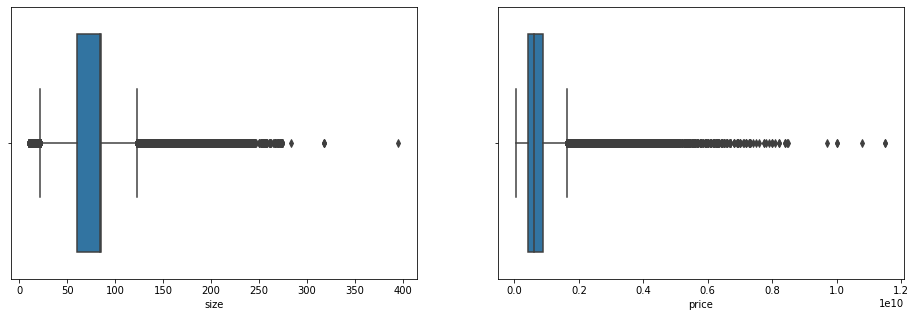

In [ ]:
# Check the distribution of continuous numerical columns, '건물면적' (size) and '물건금액' (target).
col_list = ['size', 'price']

def checkOutlier(df, cols):
  fig, axes = plt.subplots(1, 2, figsize=(16, 5))
  for i, col in enumerate(col_list):
    sns.boxplot(x=col, data=df, ax=axes[i])

checkOutlier(df, col_list)

,report_year,size,floor,price,built_year,years,is_high_price
count,376292.000000,376292.000000,376292.000000,3.762920e+05,376292.000000,376292.000000,376292.000000
mean,2018.675396,77.440978,9.108179,7.393733e+08,1999.931006,18.744390,0.237071
std,1.348699,26.961035,6.117134,4.934645e+08,9.672047,9.670277,0.425287
min,2017.000000,14.495000,1.000000,5.400000e+07,1961.000000,0.000000,0.000000
25%,2017.000000,59.760000,4.000000,4.160000e+08,1993.000000,12.000000,0.000000
50%,2019.000000,83.690000,8.000000,6.000000e+08,2000.000000,18.000000,0.000000
75%,2020.000000,84.970000,13.000000,8.950000e+08,2006.000000,25.000000,0.000000
max,2021.000000,176.560000,69.000000,6.300000e+09,2021.000000,60.000000,1.000000


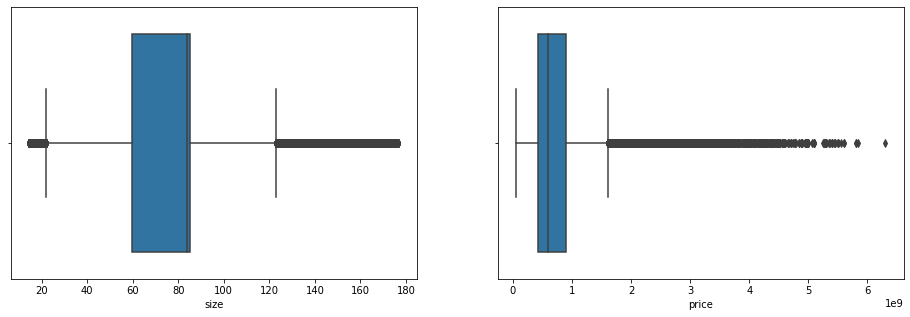

In [ ]:
# Remove values in '건물면적' (size) that exceed 300 and values below 14,
# considering the minimum housing area per person according to the revised Housing Law in 2011 is 14 square meters.
# df = df[(df['size'] <= 300) & (df['size'] >= 14)]

# Change to removing outliers at both ends
df = df[(df['size'] < np.percentile(df['size'], 99)) & (df['size'] >np.percentile(df['size'], 1))] # 상하 1%씩 제거

checkOutlier(df, col_list)
df.describe()

,report_year,size,floor,price,built_year,years,is_high_price
count,368681.000000,368681.000000,368681.000000,3.686810e+05,368681.000000,368681.000000,368681.000000
mean,2018.663628,77.487756,9.087859,7.210654e+08,1999.880531,18.783097,0.231664
std,1.345566,26.025850,6.055382,4.273172e+08,9.528356,9.528667,0.421896
min,2017.000000,14.520000,1.000000,1.535000e+08,1961.000000,0.000000,0.000000
25%,2017.000000,59.760000,4.000000,4.200000e+08,1993.000000,12.000000,0.000000
50%,2019.000000,83.710000,8.000000,6.000000e+08,2000.000000,18.000000,0.000000
75%,2020.000000,84.970000,13.000000,8.900000e+08,2006.000000,25.000000,0.000000
max,2021.000000,176.560000,69.000000,2.599980e+09,2021.000000,60.000000,1.000000


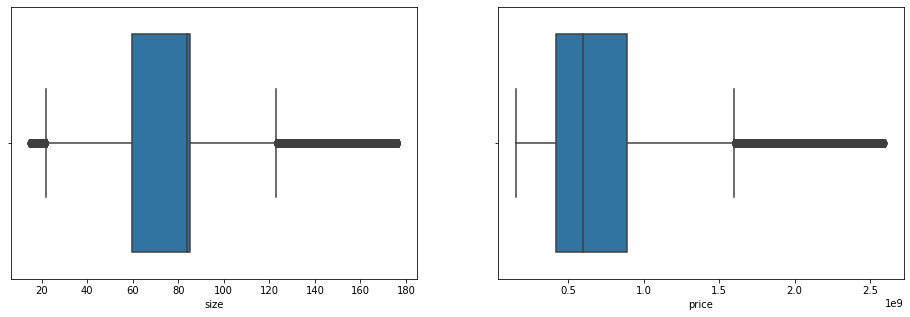

In [ ]:
# Remove data with '물건금액' (price) exceeding 9,000,000,000 KRW (90 billion), as such cases are extremely rare.
# df = df[df.price < 9000000000]

# Change to removing outliers at both ends
df = df[(df.price < np.percentile(df.price, 99)) & (df.price > np.percentile(df.price, 1))] # 상하 1% 제거

checkOutlier(df, col_list)
df.describe()

In [ ]:
# Remove data where the length of the '지번코드' (land code) is not 19
df = df[df['addr_code'].map(str).apply(len) == 19]

In [ ]:
df[df['addr_code'].map(str).apply(len) != 19]

,addr_code,city_name,area_name,report_year,size,floor,price,built_year,years,size_grade,is_high_price


In [ ]:
# Remove the '지번코드' column - potential performance degradation factor
df = df.drop('addr_code', axis=1)

In [ ]:
# Reindex the DataFrame
df = df.sort_values(by='report_year', ascending=True).reset_index(drop=True)

df.head()

,city_name,area_name,report_year,size,floor,price,built_year,years,size_grade,is_high_price
0,서초구,서초동,2017,84.98,6,1180000000,2006,11,M,1
1,강동구,성내동,2017,84.91,6,500000000,2002,15,M,0
2,강동구,명일동,2017,84.76,5,395000000,2004,13,M,0
3,강동구,둔촌동,2017,88.26,4,1015000000,1980,37,L,1
4,강동구,천호동,2017,83.15,13,378000000,1998,19,M,0


### 5) Considered as categorical columns and selected for type conversion - Excluded from execution

In [ ]:
# Convert '신고년도', '층수', '건축년도' to categorical type
# Because these are not continuous numerical values
# This is done to distinguish the differences between each year and floor level
# df[['report_year', 'floor', 'built_year']] = df[['report_year', 'floor', 'built_year']].astype(str)

In [ ]:
df.dtypes

city_name         object
area_name         object
report_year        int64
size             float64
floor              int64
price              int64
built_year         int64
years              int64
size_grade        object
is_high_price      int64
dtype: object

### 6) Baseline model visualization and baseline performance check

- For the regression problem, check the mean and median of the '물건금액' (price) as the baseline model

- For the classification problem, check the class ratio of '고가주택 여부' (is_high_price) as the baseline model

- After that, check the values of the appropriate evaluation metrics for each baseline model

In [ ]:
# Explore the correlation between features and the target variable (price)
df.corr()

,report_year,size,floor,price,built_year,years,is_high_price
report_year,1.000000,-0.078782,-0.006317,0.260802,0.070337,0.070880,0.213283
size,-0.078782,1.000000,0.110560,0.494603,0.093117,-0.104238,0.362415
floor,-0.006317,0.110560,1.000000,0.162913,0.180183,-0.181068,0.124460
price,0.260802,0.494603,0.162913,1.000000,0.084837,-0.048005,0.817549
built_year,0.070337,0.093117,0.180183,0.084837,1.000000,-0.990029,0.066583
years,0.070880,-0.104238,-0.181068,-0.048005,-0.990029,1.000000,-0.036462
is_high_price,0.213283,0.362415,0.124460,0.817549,0.066583,-0.036462,1.000000


721039891.5832587 600000000.0


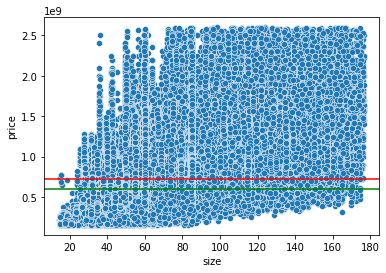

In [ ]:
# Visualize the relationship between the feature 'size' and the target variable 'price'
# Note: 'is_high_price' is a separate target for classification and is not considered for correlation analysis
baseline_mean = df.price.mean() # Baseline model: Mean value of the target 'price'
baseline_median = df.price.median() # Baseline model: Median value of the target 'price'
print(baseline_mean, baseline_median)

sns.scatterplot(x='size', y='price', data=df)
plt.axhline(baseline_mean, color='red'); # Visualize the baseline model (mean) line
plt.axhline(baseline_median, color='green'); # Visualize the baseline model (median) line

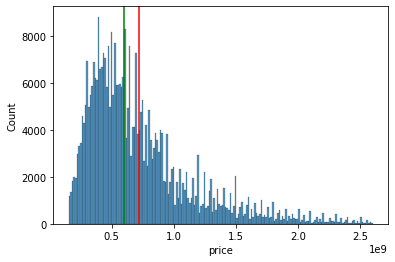

In [ ]:
# Explore the distribution of the target variable 'price'
sns.histplot(df.price, kde=False)
plt.axvline(baseline_mean, color='red'); # Visualize the baseline model (mean) line
plt.axvline(baseline_median, color='green'); # Visualize the baseline model (median) line
# Since 'price' is right-skewed, log transformation may be necessary

In [ ]:
# Baseline Performance (Regression)
errors_mean = baseline_mean - df.price
errors_median = baseline_median - df.price
baseline_mean_mae = errors_mean.abs().mean()
baseline_median_mae = errors_median.abs().mean()
baseline_mean_mae, baseline_median_mae

(321236959.3107223, 306242762.9858681)

0    0.768359
1    0.231641
Name: is_high_price, dtype: float64

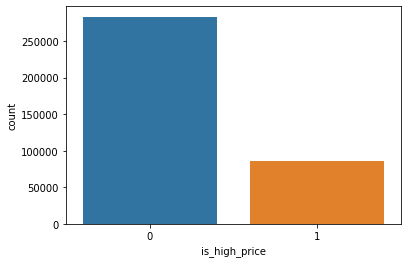

In [ ]:
# Explore the distribution of the target variable 'is_high_price'
# Baseline Performance (Classification): Ratio of non-high-priced items (0.768)
sns.countplot(x=df.is_high_price);
df.is_high_price.value_counts(normalize=True)
# Since 'is_high_price' has imbalanced class ratios, class_weight-related settings are necessary

## 4. Applying Machine Learning Techniques and Cross-Validation


In [ ]:
# Splitting into Training / Validation / Test datasets
# Based on the 'report_year', the test set corresponds to the year 2021,
# the validation set corresponds to 2020, and the rest is designated as the training dataset.
test = df[df.report_year.astype(int) == 2021]
val = df[df.report_year.astype(int) == 2020]
train = df[df.report_year.astype(int) <= 2019]

In [ ]:
train.shape, val.shape, test.shape

((247965, 10), (83748, 10), (36957, 10))

In [ ]:
# Separating Features and Target
target = 'price' # Regression problem target
target_cl = 'is_high_price' # Classification problem target
targets = [target, target_cl]
features = train.drop(columns=targets).columns

X_train = train[features]
y_train = train[target]
y_train_cl = train[target_cl]
X_val = val[features]
y_val = val[target]
y_val_cl = val[target_cl]
X_test = test[features]
y_test = test[target]
y_test_cl = test[target_cl]

X_train.head()

# Prevention of information leakage completed
# 1) All features are determined before the target result is determined.
# 2) Training / validation / test datasets are completely separated based on the 'report_year'.

,city_name,area_name,report_year,size,floor,built_year,years,size_grade
0,서초구,서초동,2017,84.98,6,2006,11,M
1,강동구,성내동,2017,84.91,6,2002,15,M
2,강동구,명일동,2017,84.76,5,2004,13,M
3,강동구,둔촌동,2017,88.26,4,1980,37,L
4,강동구,천호동,2017,83.15,13,1998,19,M


In [ ]:
eval_set = [(X_train, y_train),
            (X_val, y_val)]

In [ ]:
# addr_code, type, built_year : TargetEncoder
tge_col = ['city_name', 'area_name']
# tge_col = ['addr_code', 'city_name', 'area_name']
# size_grade : OrdinalEncoder
ord_col = ['size_grade']

In [ ]:
# Calculate class weights
# n_samples / (n_classes * np.bincount(y))
custom = len(y_train_cl)/(2*np.bincount(y_train_cl))

In [ ]:
# 1. Regression
# 1-1. Ridge Regression
alphas = [0, 0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000]

pipe_ridge = make_pipeline(
    TargetEncoder(cols=tge_col),
    OrdinalEncoder(cols=ord_col),
    StandardScaler(),    # Standardizing the scale of each feature
    RidgeCV(alphas=alphas, cv=5)
)

tt_ridge = TransformedTargetRegressor(regressor=pipe_ridge,
                                func=np.log1p, inverse_func=np.expm1)

tt_ridge.fit(X_train, y_train)
print('훈련 정확도: ', tt_ridge.score(X_train, y_train)) # Training accuracy
print('검증 정확도: ', tt_ridge.score(X_val, y_val)) # Validation accuracy

y_pred_ridge = tt_ridge.predict(X_test)

mae_ridge = mean_absolute_error(y_test, y_pred_ridge)
r2_ridge = r2_score(y_test, y_pred_ridge)
print(f'Test MAE: {mae_ridge:,.0f}')
print(f'R2 Score: {r2_ridge:,.4f}\n')

print(f'alpha: {tt_ridge.regressor_.named_steps.ridgecv.alpha_}')

훈련 정확도:  0.9257946953306045
검증 정확도:  0.7727730709321061
Test MAE: 197,243,934
R2 Score: 0.6793

alpha: 1000.0


In [ ]:
# 1-2. Decision Tree
pipe_dt = make_pipeline(
    TargetEncoder(cols=tge_col),
    OrdinalEncoder(cols=ord_col),
    DecisionTreeRegressor(random_state=2)
)

tt_dt = TransformedTargetRegressor(regressor=pipe_dt,
                                func=np.log1p, inverse_func=np.expm1)

tt_dt.fit(X_train, y_train)
print('훈련 정확도: ', tt_dt.score(X_train, y_train)) # Training accuracy
print('검증 정확도: ', tt_dt.score(X_val, y_val)) # Validation accuracy

y_pred_dt = tt_dt.predict(X_test)

mae_dt = mean_absolute_error(y_test, y_pred_dt)
r2_dt = r2_score(y_test, y_pred_dt)
print(f'Test MAE: {mae_dt:,.0f}')
print(f'R2 Score: {r2_dt:,.4f}\n')

훈련 정확도:  0.9941465846848493
검증 정확도:  0.7396226475971815
Test MAE: 307,265,136
R2 Score: 0.4212



In [ ]:
# Perform optimization along with reducing overfitting
dists = {
    'decisiontreeregressor__splitter': ['best', 'random'],
    'decisiontreeregressor__max_depth': [5, 10, 15, 20, None],
    'decisiontreeregressor__min_samples_split': randint(2, 50),
    'decisiontreeregressor__min_samples_leaf': randint(1, 50),
    'decisiontreeregressor__max_features': uniform(0, 1)
}

clf = RandomizedSearchCV(
    pipe_dt,
    param_distributions=dists,
    n_iter=30,
    cv=3,
    scoring='r2',
    verbose=1,
    n_jobs=-1
)

clf.fit(X_train, y_train);

Fitting 3 folds for each of 30 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   31.3s
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:  1.0min finished


In [ ]:
tt_dt_opt = TransformedTargetRegressor(regressor=clf.best_estimator_,
                                func=np.log1p, inverse_func=np.expm1)

tt_dt_opt.fit(X_train, y_train)
print('훈련 정확도: ', tt_dt_opt.score(X_train, y_train)) # Training accuracy
print('검증 정확도: ', tt_dt_opt.score(X_val, y_val)) # Validation accuracy

y_pred_dt_opt = tt_dt_opt.predict(X_test)

mae_dt_opt = mean_absolute_error(y_test, y_pred_dt_opt)
r2_dt_opt = r2_score(y_test, y_pred_dt_opt)
print(f'Test MAE: {mae_dt_opt:,.0f}')
print(f'R2 Score: {r2_dt_opt:,.4f}\n')

훈련 정확도:  0.9707393193082943
검증 정확도:  0.74694428387824
Test MAE: 315,003,142
R2 Score: 0.3889



In [ ]:
# 1-3. Random Forest
pipe_rf = make_pipeline(
    TargetEncoder(cols=tge_col),
    OrdinalEncoder(cols=ord_col),
    RandomForestRegressor(n_jobs=-1, random_state=2)
)

tt_rf = TransformedTargetRegressor(regressor=pipe_rf,
                                func=np.log1p, inverse_func=np.expm1)

tt_rf.fit(X_train, y_train)
print('훈련 정확도: ', tt_rf.score(X_train, y_train)) # Training accuracy
print('검증 정확도: ', tt_rf.score(X_val, y_val)) # Validation accuracy

y_pred_rf = tt_rf.predict(X_test)

mae_rf = mean_absolute_error(y_test, y_pred_rf)
r2_rf = r2_score(y_test, y_pred_rf)
print(f'Test MAE: {mae_rf:,.0f}')
print(f'R2 Score: {r2_rf:,.4f}')

훈련 정확도:  0.9915777854035414
검증 정확도:  0.7672830533949198
Test MAE: 308,733,533
R2 Score: 0.4323


In [ ]:
# Perform optimization along with reducing overfitting
dists_rf = {
    'randomforestregressor__n_estimators': randint(50, 500),
    'randomforestregressor__max_depth': [5, 10, 15, 20, None],
    'randomforestregressor__min_samples_split': randint(2, 50),
    'randomforestregressor__min_samples_leaf': randint(1, 50),
    'randomforestregressor__max_features': uniform(0, 1)
}

clf_rf = RandomizedSearchCV(
    pipe_rf,
    param_distributions=dists_rf,
    n_iter=30,
    cv=3,
    scoring='r2',
    verbose=1,
    n_jobs=-1
)

clf_rf.fit(X_train, y_train);

Fitting 3 folds for each of 30 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed: 31.0min
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed: 63.1min finished


In [ ]:
tt_rf_opt = TransformedTargetRegressor(regressor=clf_rf.best_estimator_,
                                func=np.log1p, inverse_func=np.expm1)

tt_rf_opt.fit(X_train, y_train)
print('훈련 정확도: ', tt_rf_opt.score(X_train, y_train)) # Training accuracy
print('검증 정확도: ', tt_rf_opt.score(X_val, y_val)) # Validation accuracy

y_pred_rf_opt = tt_rf_opt.predict(X_test)

mae_rf_opt = mean_absolute_error(y_test, y_pred_rf_opt)
r2_rf_opt = r2_score(y_test, y_pred_rf_opt)
print(f'Test MAE: {mae_rf_opt:,.0f}')
print(f'R2 Score: {r2_rf_opt:,.4f}')

훈련 정확도:  0.9509698750188326
검증 정확도:  0.6990845375382275
Test MAE: 321,812,019
R2 Score: 0.3484


In [ ]:
# 1-4. Boosting
pipe_xgb = make_pipeline(
    TargetEncoder(cols=tge_col),
    OrdinalEncoder(cols=ord_col),
    XGBRegressor(n_estimators=1000
              , random_state=2
              , n_jobs=-1
              , eval_set=eval_set
              , eval_metric='mae'
              , early_stopping_rounds=20) # Stop if there is no improvement in the score for 50 rounds
)

dists_xgb = {
    'xgbregressor__max_depth': [1, 2, 3, 4, 5],
    'xgbregressor__learning_rate': uniform(0.01, 0.2),
    'xgbregressor__subsample': uniform(0.5, 1),
    'xgbregressor__colsample_bytree': uniform(0.5, 1),
    'xgbregressor__max_features': uniform(0, 1)
}

clf_xgb = RandomizedSearchCV(
    pipe_xgb,
    param_distributions=dists_xgb,
    n_iter=30,
    cv=3,
    scoring='r2',
    verbose=1,
    n_jobs=-1
)

clf_xgb.fit(X_train, y_train);

Fitting 3 folds for each of 30 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed: 12.7min
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed: 30.7min finished


[08:21:26] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [ ]:
tt_xgb = TransformedTargetRegressor(regressor=clf_xgb.best_estimator_,
                                func=np.log1p, inverse_func=np.expm1)

tt_xgb.fit(X_train, y_train);

y_pred_xgb_train = tt_xgb.predict(X_train)
mae_xgb_train = mean_absolute_error(y_train, y_pred_xgb_train)
r2_xgb_train = r2_score(y_train, y_pred_xgb_train)
print(f'Train MAE: {mae_xgb_train:,.0f}')
print(f'R2 Score: {r2_xgb_train:,.4f}\n')

y_pred_xgb_val = tt_xgb.predict(X_val)
mae_xgb_val = mean_absolute_error(y_val, y_pred_xgb_val)
r2_xgb_val = r2_score(y_val, y_pred_xgb_val)
print(f'Val MAE: {mae_xgb_val:,.0f}')
print(f'R2 Score: {r2_xgb_val:,.4f}\n')

y_pred_xgb = tt_xgb.predict(X_test)
mae_xgb = mean_absolute_error(y_test, y_pred_xgb)
r2_xgb = r2_score(y_test, y_pred_xgb)
print(f'Test MAE: {mae_xgb:,.0f}')
print(f'R2 Score: {r2_xgb:,.4f}')

[08:24:19] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Train MAE: 43,425,757
R2 Score: 0.9724

Val MAE: 154,511,665
R2 Score: 0.7580

Test MAE: 311,926,349
R2 Score: 0.4107


In [ ]:
### Classification problem evaluation function
def clf_eval(model):
  fig, ax = plt.subplots(1, 2, figsize=(16, 8))
  pcm = plot_confusion_matrix(model, X_val, y_val_cl,
                              cmap=plt.cm.Blues,
                              ax=ax[0]);
  plt.title(f'Confusion matrix, n = {len(y_val_cl)}', fontsize=15)

  y_val_pred = model.predict(X_val)
  print(classification_report(y_val_cl, y_val_pred))

  y_val_pred_proba = model.predict_proba(X_val)[:, -1]
  print('AUC score: ', roc_auc_score(y_val_cl, y_val_pred_proba))
  fpr, tpr, thresholds = roc_curve(y_val_cl, y_val_pred_proba)
  plt.scatter(fpr, tpr, color='blue')
  plt.plot(fpr, tpr, color='green')
  plt.title('ROC curve')
  plt.xlabel('FPR')
  plt.ylabel('TPR')

  # Index of the maximum threshold, np.argmax()
  optimal_idx = np.argmax(tpr - fpr) # Find the index of data that maximizes recall and minimizes false positive rate
  optimal_threshold = thresholds[optimal_idx] # Get the threshold value at that index

  print('idx:', optimal_idx, ', threshold:', optimal_threshold)

  # Applying the optimal threshold
  y_pred_proba_train = model.predict_proba(X_train)[:, 1] # Get the probability of target being 1 (True)
  y_pred_proba_val = model.predict_proba(X_val)[:, 1] # Get the probability of target being 1 (True)
  y_pred_proba_test = model.predict_proba(X_test)[:, 1] # Get the probability of target being 1 (True)
  y_pred_train = y_pred_proba_train > optimal_threshold
  y_pred_val = y_pred_proba_val > optimal_threshold
  y_pred_test = y_pred_proba_test > optimal_threshold

  f1_train = f1_score(y_train_cl, y_pred_train)
  print(f'Train F1: {f1_train}')

  f1_val = f1_score(y_val_cl, y_pred_val)
  print(f'Val F1: {f1_val}')

  f1_test = f1_score(y_test_cl, y_pred_test)
  print(f'Test F1: {f1_test}')

In [ ]:
# 2. Classification
# 2-1. Logistic Regression

pipe_logis = make_pipeline(
    TargetEncoder(cols=tge_col),
    OrdinalEncoder(cols=ord_col),
    StandardScaler(),    # Standardize each feature
    LogisticRegression(class_weight={False:custom[0],True:custom[1]}, random_state=2)
)

pipe_logis.fit(X_train, y_train_cl)
print('훈련 정확도: ', pipe_logis.score(X_train, y_train_cl)) # Training accuracy
print('검증 정확도: ', pipe_logis.score(X_val, y_val_cl)) # Validation accuracy

y_pred_logis = pipe_logis.predict(X_test)

f1_logis = f1_score(y_test_cl, y_pred_logis)
print(f'Test F1: {f1_logis}')

훈련 정확도:  0.9073578932510636
검증 정확도:  0.7180589387209246
Test F1: 0.725778038755138


In [ ]:
y_test_pred_proba = pipe_logis.predict_proba(X_test)[:, -1]
fpr, tpr, thresholds = roc_curve(y_test_cl, y_test_pred_proba)

optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_idx]

y_pred_proba_test = pipe_logis.predict_proba(X_test)[:, 1]
y_pred_test = y_pred_proba_test > optimal_threshold
print(classification_report(y_test_cl, y_pred_test))

              precision    recall  f1-score   support

           0       0.83      0.82      0.82     21155
           1       0.76      0.77      0.77     15802

    accuracy                           0.80     36957
   macro avg       0.80      0.80      0.80     36957
weighted avg       0.80      0.80      0.80     36957



              precision    recall  f1-score   support

           0       0.96      0.63      0.76     59138
           1       0.51      0.94      0.66     24610

    accuracy                           0.72     83748
   macro avg       0.74      0.78      0.71     83748
weighted avg       0.83      0.72      0.73     83748

AUC score:  0.9100035548640429
idx: 14587 , threshold: 0.6569633650058787
Train F1: 0.7933483676523279
Val F1: 0.7488965179009318
Test F1: 0.7446765566656575


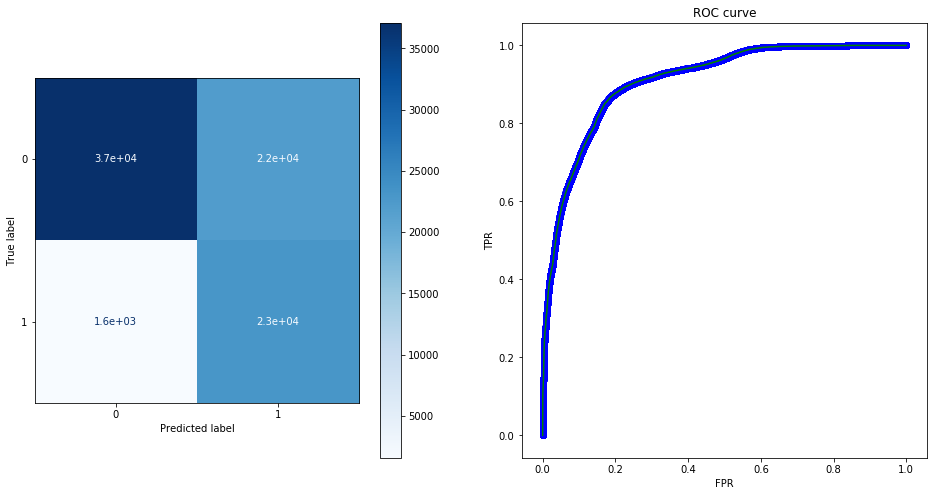

In [ ]:
clf_eval(pipe_logis)

In [ ]:
# 2-2. Decision Tree

pipe_dt = make_pipeline(
    TargetEncoder(cols=tge_col),
    OrdinalEncoder(cols=ord_col),
    DecisionTreeClassifier(class_weight={False:custom[0],True:custom[1]}, random_state=2)
)

pipe_dt.fit(X_train, y_train_cl)
print('훈련 정확도: ', pipe_dt.score(X_train, y_train_cl)) # Training accuracy
print('검증 정확도: ', pipe_dt.score(X_val, y_val_cl)) # Validation accuracy

y_pred_dt = pipe_dt.predict(X_test)

f1_dt = f1_score(y_test_cl, y_pred_dt)
print(f'Test F1: {f1_dt}')

훈련 정확도:  0.9886677555300143
검증 정확도:  0.8904570855423413
Test F1: 0.6016713091922006


In [ ]:
# Perform optimization along with reducing overfitting
dists = {
    'decisiontreeclassifier__splitter': ['best', 'random'],
    'decisiontreeclassifier__max_depth': [5, 10, 15, 20, None],
    'decisiontreeclassifier__min_samples_split': randint(2, 50),
    'decisiontreeclassifier__min_samples_leaf': randint(1, 50),
    'decisiontreeclassifier__max_features': uniform(0, 1)
}

clf = RandomizedSearchCV(
    pipe_dt,
    param_distributions=dists,
    n_iter=30,
    cv=3,
    scoring='f1',
    verbose=1,
    n_jobs=-1
)

clf.fit(X_train, y_train_cl);

print('최적 하이퍼파라미터: ', clf.best_params_) # Optimized Hyper-parameter
print('f1: ', clf.best_score_)

pipe_dt = clf.best_estimator_

Fitting 3 folds for each of 30 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   26.5s
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:   48.9s finished


최적 하이퍼파라미터:  {'decisiontreeclassifier__max_depth': 15, 'decisiontreeclassifier__max_features': 0.5356643201749111, 'decisiontreeclassifier__min_samples_leaf': 16, 'decisiontreeclassifier__min_samples_split': 20, 'decisiontreeclassifier__splitter': 'best'}
f1:  0.7114871771870933


In [ ]:
y_test_pred_proba = pipe_dt.predict_proba(X_test)[:, -1]
fpr, tpr, thresholds = roc_curve(y_test_cl, y_test_pred_proba)

optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_idx]

y_pred_proba_test = pipe_dt.predict_proba(X_test)[:, 1]
y_pred_test = y_pred_proba_test > optimal_threshold
print(classification_report(y_test_cl, y_pred_test))

              precision    recall  f1-score   support

           0       0.77      0.95      0.85     21155
           1       0.90      0.62      0.73     15802

    accuracy                           0.81     36957
   macro avg       0.83      0.78      0.79     36957
weighted avg       0.82      0.81      0.80     36957



              precision    recall  f1-score   support

           0       0.91      0.96      0.94     59138
           1       0.89      0.78      0.83     24610

    accuracy                           0.91     83748
   macro avg       0.90      0.87      0.88     83748
weighted avg       0.91      0.91      0.90     83748

AUC score:  0.9075920392483046
idx: 299 , threshold: 0.13877755853560822
Train F1: 0.819788436987051
Val F1: 0.8426916039845497
Test F1: 0.7309369830049631


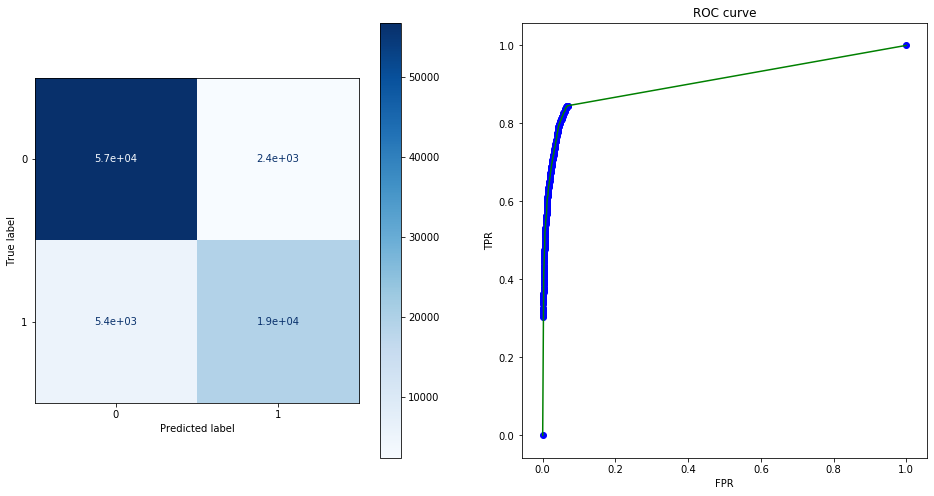

In [ ]:
clf_eval(pipe_dt)

In [ ]:
# 2-3. Random Forest
pipe_rf = make_pipeline(
    TargetEncoder(cols=tge_col),
    OrdinalEncoder(cols=ord_col),
    RandomForestClassifier(class_weight={False:custom[0],True:custom[1]}, n_jobs=-1, random_state=2)
)

pipe_rf.fit(X_train, y_train_cl)
print('훈련 정확도: ', pipe_rf.score(X_train, y_train_cl)) # Training accuracy
print('검증 정확도: ', pipe_rf.score(X_val, y_val_cl)) # Validation accuracy

y_pred_rf = pipe_rf.predict(X_test)

f1_rf = f1_score(y_test_cl, y_pred_rf)
print(f'Test F1: {f1_rf}')

훈련 정확도:  0.9903091162059161
검증 정확도:  0.8948512203276496
Test F1: 0.5923166876001559


In [ ]:
# Perform optimization along with reducing overfitting
dists_rf = {
    'randomforestclassifier__n_estimators': randint(50, 500),
    'randomforestclassifier__max_depth': [5, 10, 15, 20, None],
    'randomforestclassifier__min_samples_split': randint(2, 50),
    'randomforestclassifier__min_samples_leaf': randint(1, 50),
    'randomforestclassifier__max_features': uniform(0, 1)
}

clf_rf = RandomizedSearchCV(
    pipe_rf,
    param_distributions=dists_rf,
    n_iter=30,
    cv=3,
    scoring='f1',
    verbose=1,
    n_jobs=-1
)

clf_rf.fit(X_train, y_train_cl);

print('최적 하이퍼파라미터: ', clf_rf.best_params_) # Optimized Hyper-parameter
print('f1: ', clf_rf.best_score_)

pipe_rf = clf_rf.best_estimator_

Fitting 3 folds for each of 30 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed: 25.8min
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed: 47.3min finished


최적 하이퍼파라미터:  {'randomforestclassifier__max_depth': None, 'randomforestclassifier__max_features': 0.309075738876603, 'randomforestclassifier__min_samples_leaf': 43, 'randomforestclassifier__min_samples_split': 47, 'randomforestclassifier__n_estimators': 158}
f1:  0.758367598892252


In [ ]:
y_test_pred = pipe_rf.predict(X_test)
print(classification_report(y_test_cl, y_test_pred))

              precision    recall  f1-score   support

           0       0.73      0.96      0.83     21155
           1       0.92      0.53      0.67     15802

    accuracy                           0.78     36957
   macro avg       0.83      0.75      0.75     36957
weighted avg       0.81      0.78      0.77     36957



In [ ]:
y_test_pred_proba = pipe_rf.predict_proba(X_test)[:, -1]
fpr, tpr, thresholds = roc_curve(y_test_cl, y_test_pred_proba)

optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_idx]

y_pred_proba_test = pipe_rf.predict_proba(X_test)[:, 1]
y_pred_test = y_pred_proba_test > optimal_threshold
print(classification_report(y_test_cl, y_pred_test))

              precision    recall  f1-score   support

           0       0.84      0.83      0.84     21155
           1       0.78      0.80      0.79     15802

    accuracy                           0.82     36957
   macro avg       0.81      0.81      0.81     36957
weighted avg       0.82      0.82      0.82     36957



              precision    recall  f1-score   support

           0       0.91      0.96      0.93     59138
           1       0.89      0.76      0.82     24610

    accuracy                           0.90     83748
   macro avg       0.90      0.86      0.88     83748
weighted avg       0.90      0.90      0.90     83748

AUC score:  0.9591392794454047
idx: 11011 , threshold: 0.20634539120133918
Train F1: 0.7696894920830762
Val F1: 0.8274521018015442
Test F1: 0.7534873815355128


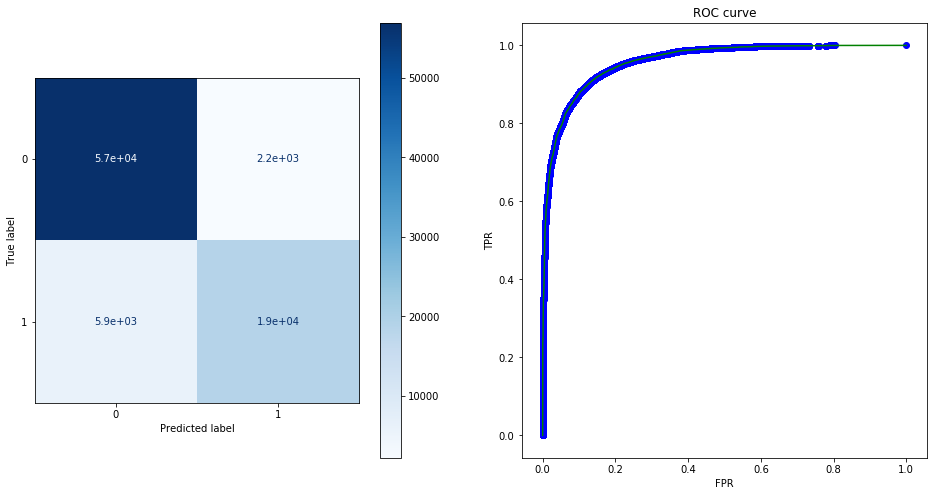

In [ ]:
clf_eval(pipe_rf)

In [ ]:
# 2-4. Boosting
pipe_xgb_cl = make_pipeline(
    TargetEncoder(cols=tge_col),
    OrdinalEncoder(cols=ord_col),
    XGBClassifier(n_estimators=1000
              , random_state=2
              , n_jobs=-1
              , eval_set=eval_set
              , eval_metric='error'
              , scale_pos_weight=(custom[0]/custom[1])
              , early_stopping_rounds=20) # Stop if there is no improvement in the score for 20 rounds
)

pipe_xgb_cl.fit(X_train, y_train_cl);

y_pred_xgb_cl_train = pipe_xgb_cl.predict(X_train)
f1_rf_cl = f1_score(y_train_cl, y_pred_xgb_cl_train)
print(f'Train F1: {f1_rf_cl}')

y_pred_xgb_cl_val = pipe_xgb_cl.predict(X_val)
f1_rf_cl = f1_score(y_val_cl, y_pred_xgb_cl_val)
print(f'Val F1: {f1_rf_cl}')

y_pred_xgb_cl = pipe_xgb_cl.predict(X_test)
f1_rf_cl = f1_score(y_test_cl, y_pred_xgb_cl)
print(f'Test F1: {f1_rf_cl}')

Train F1: 0.8474354127284184
Val F1: 0.6565629374394315
Test F1: 0.4818207309094308


In [ ]:
# Perform optimization along with reducing overfitting
dists_xgb_cl = {
    'xgbclassifier__max_depth': [1, 2, 3, 4, 5],
    'xgbclassifier__learning_rate': uniform(0.01, 0.2),
    'xgbclassifier__subsample': uniform(0.5, 1),
    'xgbclassifier__colsample_bytree': uniform(0.5, 1),
    'xgbclassifier__max_features': uniform(0, 1)
}

clf_xgb_cl = RandomizedSearchCV(
    pipe_xgb_cl,
    param_distributions=dists_xgb_cl,
    n_iter=30,
    cv=3,
    scoring='f1',
    verbose=1,
    n_jobs=-1
)

clf_xgb_cl.fit(X_train, y_train_cl);

print('최적 하이퍼파라미터: ', clf_xgb_cl.best_params_) # Optimized Hyper-parameter
print('f1: ', clf_xgb_cl.best_score_)

Fitting 3 folds for each of 30 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed: 13.1min
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed: 13.9min finished


최적 하이퍼파라미터:  {'xgbclassifier__colsample_bytree': 0.7232350591077772, 'xgbclassifier__learning_rate': 0.02901875232549015, 'xgbclassifier__max_depth': 1, 'xgbclassifier__max_features': 0.8704111045670669, 'xgbclassifier__subsample': 0.9908933449488576}
f1:  0.6334726425534517


In [ ]:
pipe_xgb_cl = clf_xgb_cl.best_estimator_

y_pred_xgb_cl_train = pipe_xgb_cl.predict(X_train)
f1_rf_cl = f1_score(y_train_cl, y_pred_xgb_cl_train)
print(f'Train F1: {f1_rf_cl}')

y_pred_xgb_cl_val = pipe_xgb_cl.predict(X_val)
f1_rf_cl = f1_score(y_val_cl, y_pred_xgb_cl_val)
print(f'Val F1: {f1_rf_cl}')

y_pred_xgb_cl = pipe_xgb_cl.predict(X_test)
f1_rf_cl = f1_score(y_test_cl, y_pred_xgb_cl)
print(f'Test F1: {f1_rf_cl}')

Train F1: 0.6984864145440128
Val F1: 0.5064185044435799
Test F1: 0.35620600597559127


In [ ]:
y_test_pred_proba = pipe_xgb_cl.predict_proba(X_test)[:, -1]
fpr, tpr, thresholds = roc_curve(y_test_cl, y_test_pred_proba)

optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_idx]

y_pred_proba_test = pipe_xgb_cl.predict_proba(X_test)[:, 1]
y_pred_test = y_pred_proba_test > optimal_threshold
print(classification_report(y_test_cl, y_pred_test))

              precision    recall  f1-score   support

           0       0.87      0.79      0.83     21155
           1       0.75      0.85      0.79     15802

    accuracy                           0.81     36957
   macro avg       0.81      0.82      0.81     36957
weighted avg       0.82      0.81      0.81     36957



              precision    recall  f1-score   support

           0       0.78      0.99      0.88     59138
           1       0.96      0.34      0.51     24610

    accuracy                           0.80     83748
   macro avg       0.87      0.67      0.69     83748
weighted avg       0.84      0.80      0.77     83748

AUC score:  0.9433420121524034
idx: 8670 , threshold: 0.023456085
Train F1: 0.7038162036781356
Val F1: 0.7963670780095374
Test F1: 0.7532752589340833


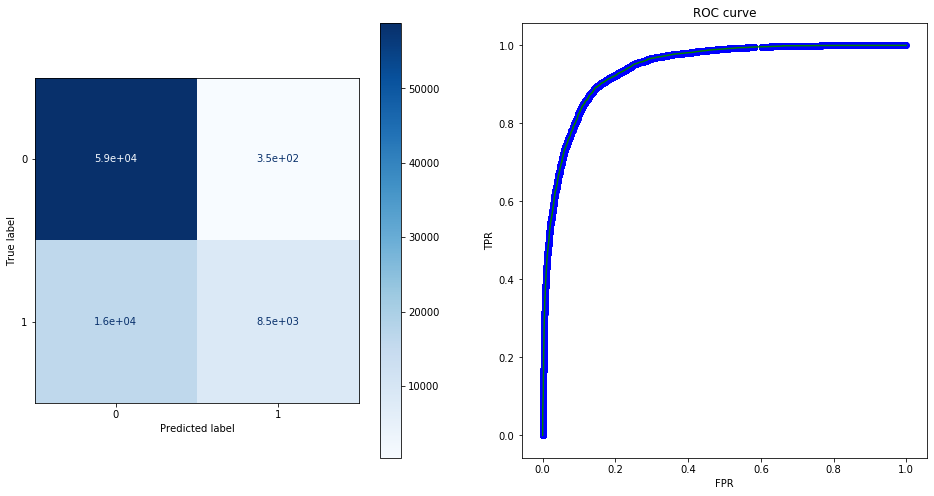

In [ ]:
clf_eval(pipe_xgb_cl)

In [ ]:
# Classification Final Model: Random Forest
# Achieved the highest F1 Score on the test set
X_total = pd.concat([X_train, X_val, X_test])
y_total = pd.concat([y_train_cl, y_val_cl, y_test_cl])

In [ ]:
%%time
final_model = make_pipeline(
    TargetEncoder(cols=tge_col),
    OrdinalEncoder(cols=ord_col),
    RandomForestClassifier(class_weight={False:custom[0],True:custom[1]},
                           max_depth=None,
                           max_features=0.309075738876603,
                           min_samples_leaf=43,
                           min_samples_split=47,
                           n_estimators=158,
                           n_jobs=-1, random_state=2)
)

final_model.fit(X_total, y_total)
print('훈련 정확도: ', final_model.score(X_train, y_train_cl)) # Training accuracy
print('검증 정확도: ', final_model.score(X_val, y_val_cl)) # Validation accuracy
print('테스트 정확도: ', final_model.score(X_test, y_test_cl)) # Test accuracy

훈련 정확도:  0.9426249672332789
검증 정확도:  0.8940750823900272
테스트 정확도:  0.8851638390562004
CPU times: user 1min 10s, sys: 420 ms, total: 1min 10s
Wall time: 36.9 s


In [ ]:
y_pred = final_model.predict(X_total)
print(classification_report(y_total, y_pred))

              precision    recall  f1-score   support

           0       0.99      0.91      0.95    283271
           1       0.77      0.98      0.86     85399

    accuracy                           0.93    368670
   macro avg       0.88      0.94      0.90    368670
weighted avg       0.94      0.93      0.93    368670



In [ ]:
y_pred_proba = final_model.predict_proba(X_total)[:, -1]
fpr, tpr, thresholds = roc_curve(y_total, y_pred_proba)

optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_idx]

y_pred_proba = final_model.predict_proba(X_total)[:, 1]
y_pred = y_pred_proba > optimal_threshold
print(classification_report(y_total, y_pred))

              precision    recall  f1-score   support

           0       0.99      0.93      0.96    283271
           1       0.80      0.96      0.88     85399

    accuracy                           0.94    368670
   macro avg       0.90      0.95      0.92    368670
weighted avg       0.94      0.94      0.94    368670



In [ ]:
final_model.named_steps['ordinalencoder'].mapping

[{'col': 'size_grade', 'data_type': dtype('O'), 'mapping': M      1
  L      2
  S      3
  NaN   -2
  dtype: int64}]

In [ ]:
# Save the model
# models = [final_model]
# model_save_names = ['final_model_noAddrCode']

# for model, model_save_name in zip(models, model_save_names):
#   path = F"/content/gdrive/MyDrive/Colab Notebooks/section2/project_models/{model_save_name}.joblib"
#   dump(model, path)

In [ ]:
# load the model
# for model, model_save_name in zip(models, model_save_names):
#   load_path = F"/content/gdrive/MyDrive/Colab Notebooks/section2/project_models/{model_save_name}.joblib"
#   model = load(load_path)
#   clf_eval(model)

5. Interpreting Machine Learning Model

- Use permutation importance to assess the importance of features for the target.

- Utilize Partial Dependence Plots (PDP) to understand the influence of each feature on the target's outcomes.

- Employ SHAP values to explore the impact of individual features on the target outcomes.

In [ ]:
# Adjusting visualization image resolution
plt.rcParams['figure.dpi'] = 144

In [ ]:
encoder = make_pipeline(TargetEncoder(cols=tge_col), OrdinalEncoder(cols=ord_col))
X_train_encoded = encoder.fit(X_train, y_train_cl)

X_total_transformed = encoder.transform(X_total)

feature_names = X_total.columns.tolist()

In [ ]:
# Permutation importance

permuter = PermutationImportance(
    final_model.named_steps['randomforestclassifier'], # model
    scoring='f1', # metric
    n_iter=5, # Repeating with 5 different random seeds
    random_state=2
)


permuter.fit(X_total_transformed, y_total);

In [ ]:
eli5.show_weights(
    permuter,
    top=None,
    feature_names=feature_names
)

Weight,Feature
0.3627 ± 0.0028,area_name
0.1380 ± 0.0010,report_year
0.1088 ± 0.0012,size
0.0665 ± 0.0008,city_name
0.0406 ± 0.0007,built_year
0.0210 ± 0.0007,size_grade
0.0208 ± 0.0004,years
0.0057 ± 0.0004,floor


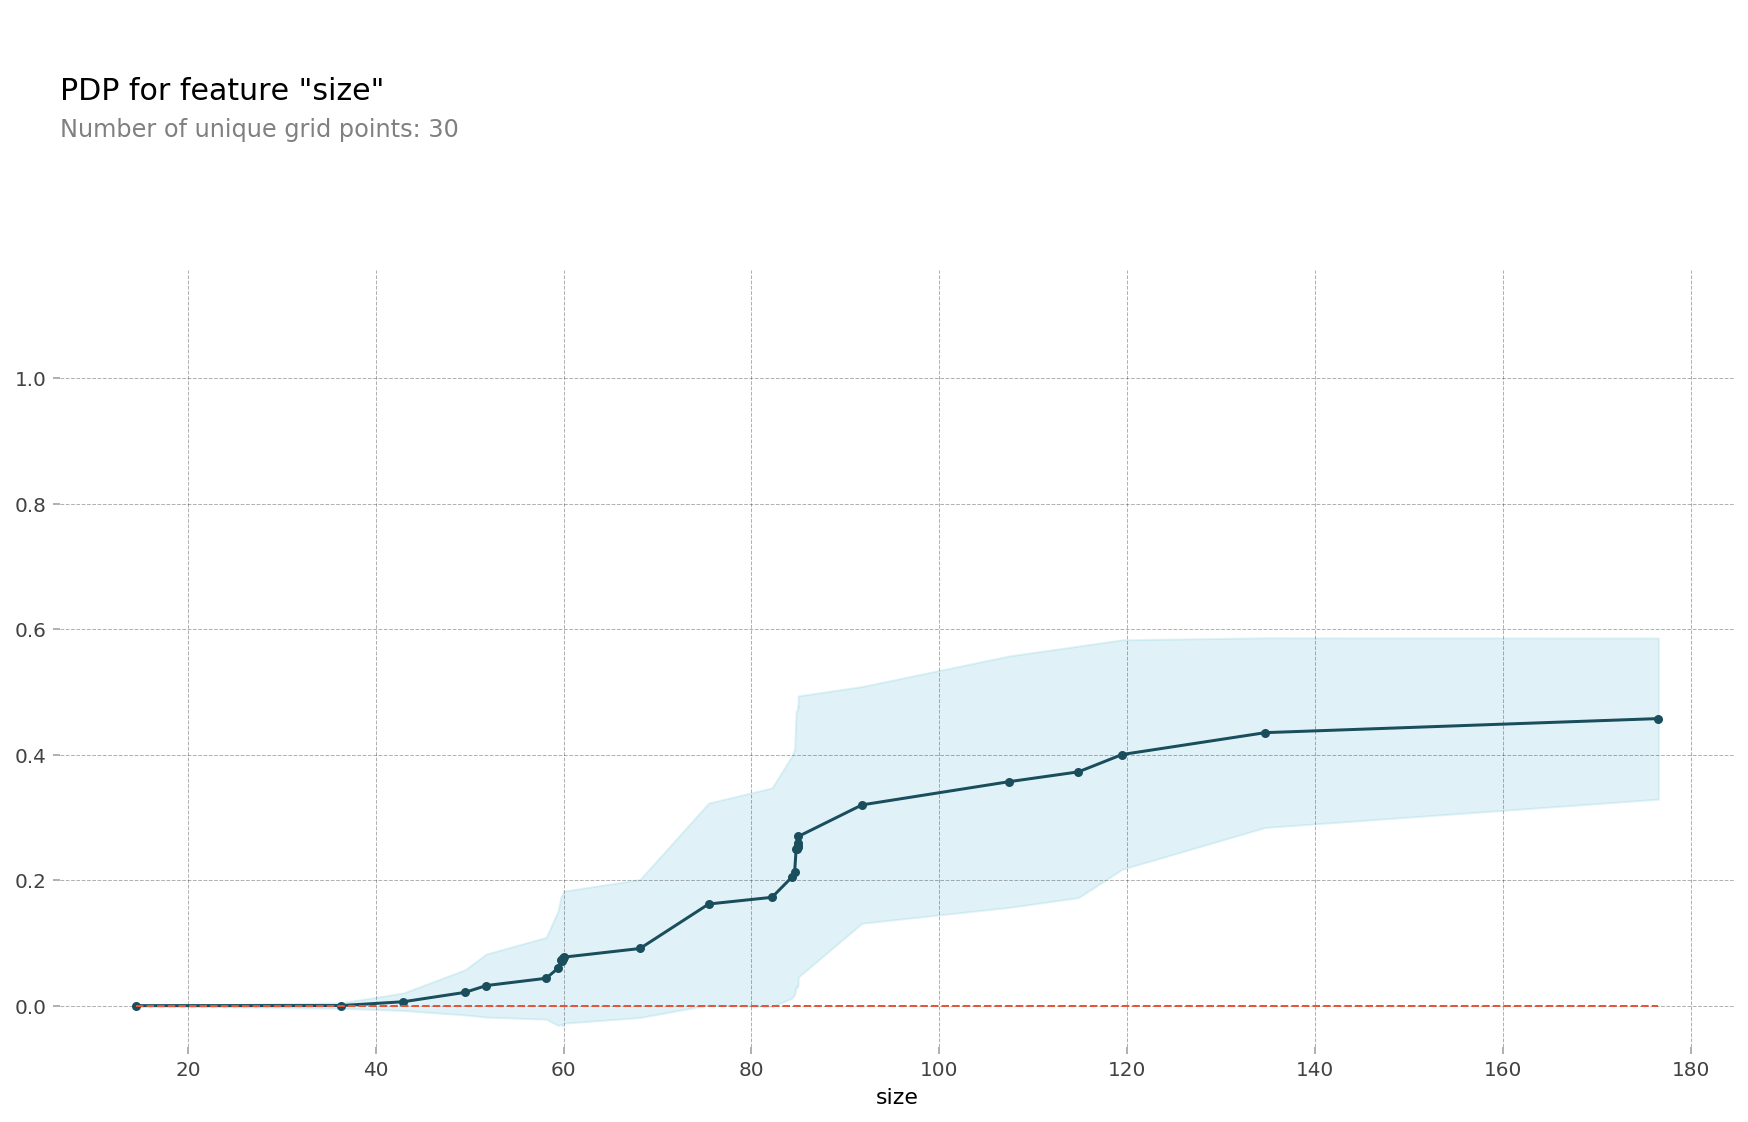

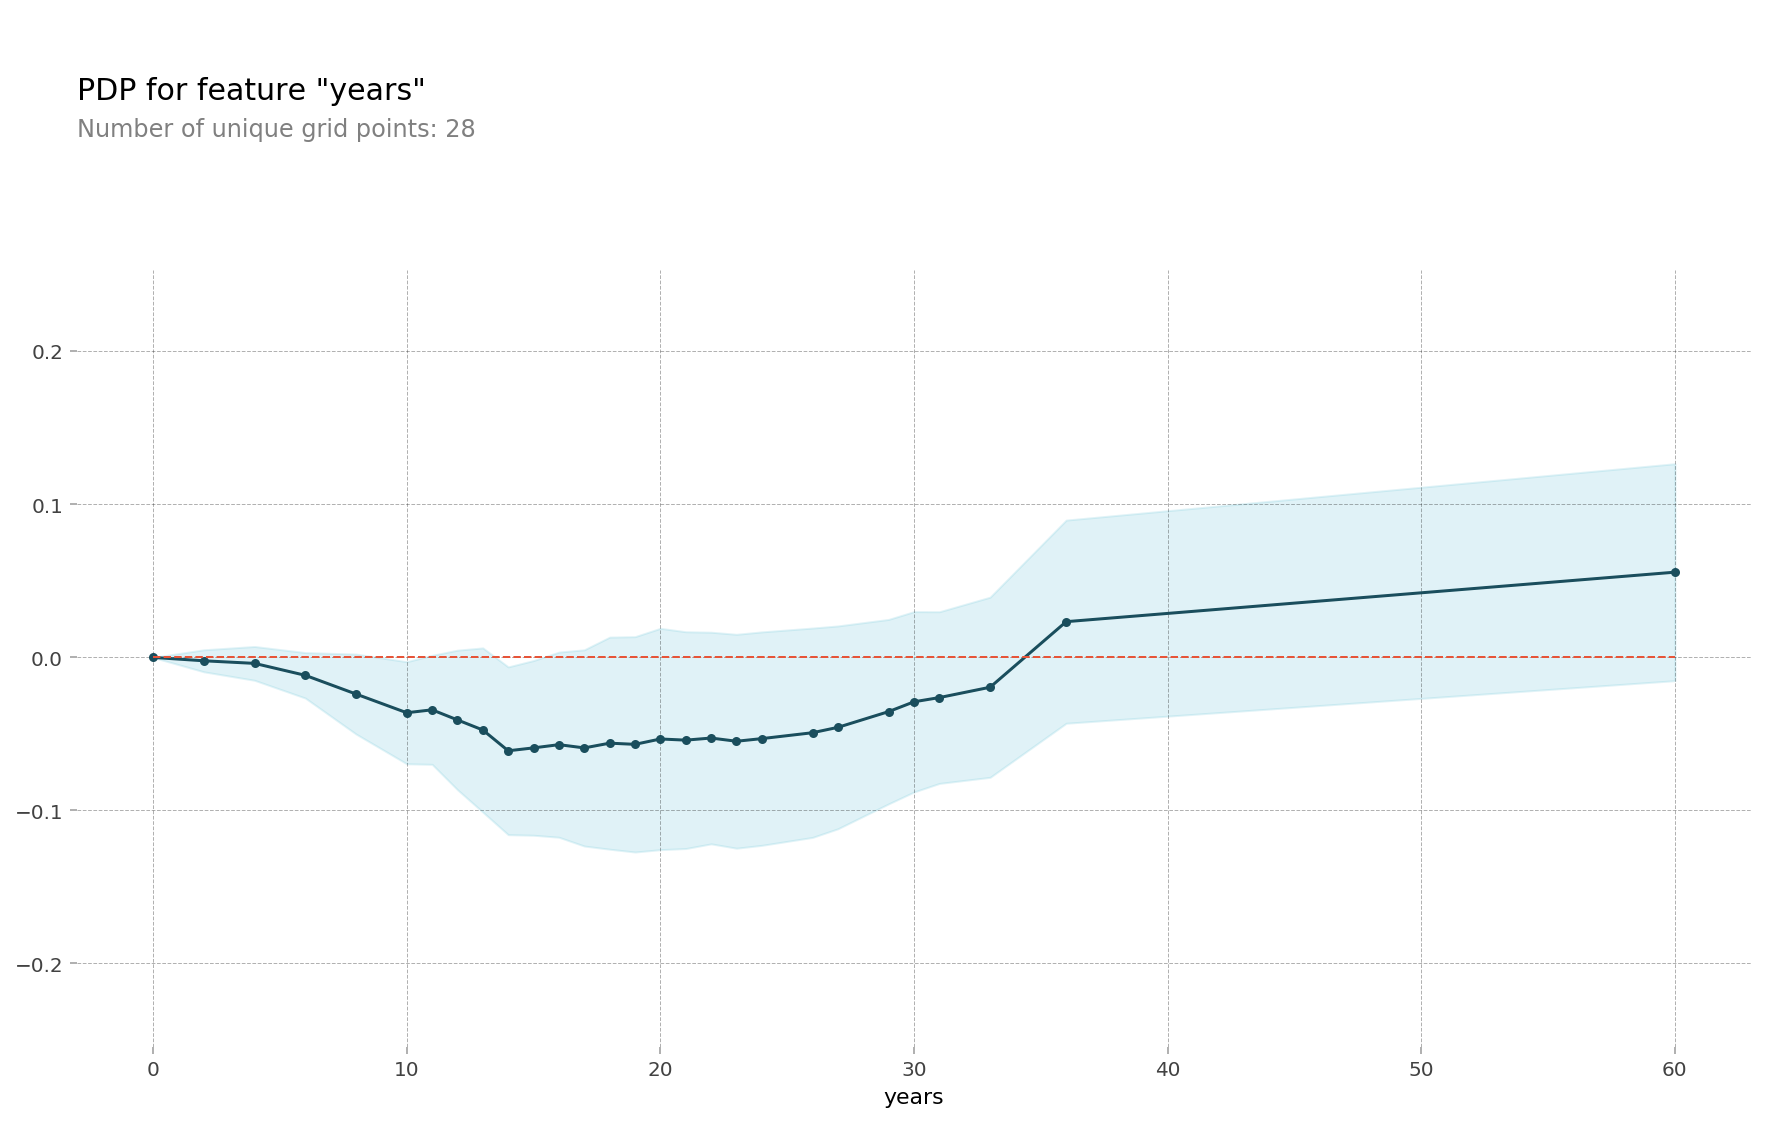

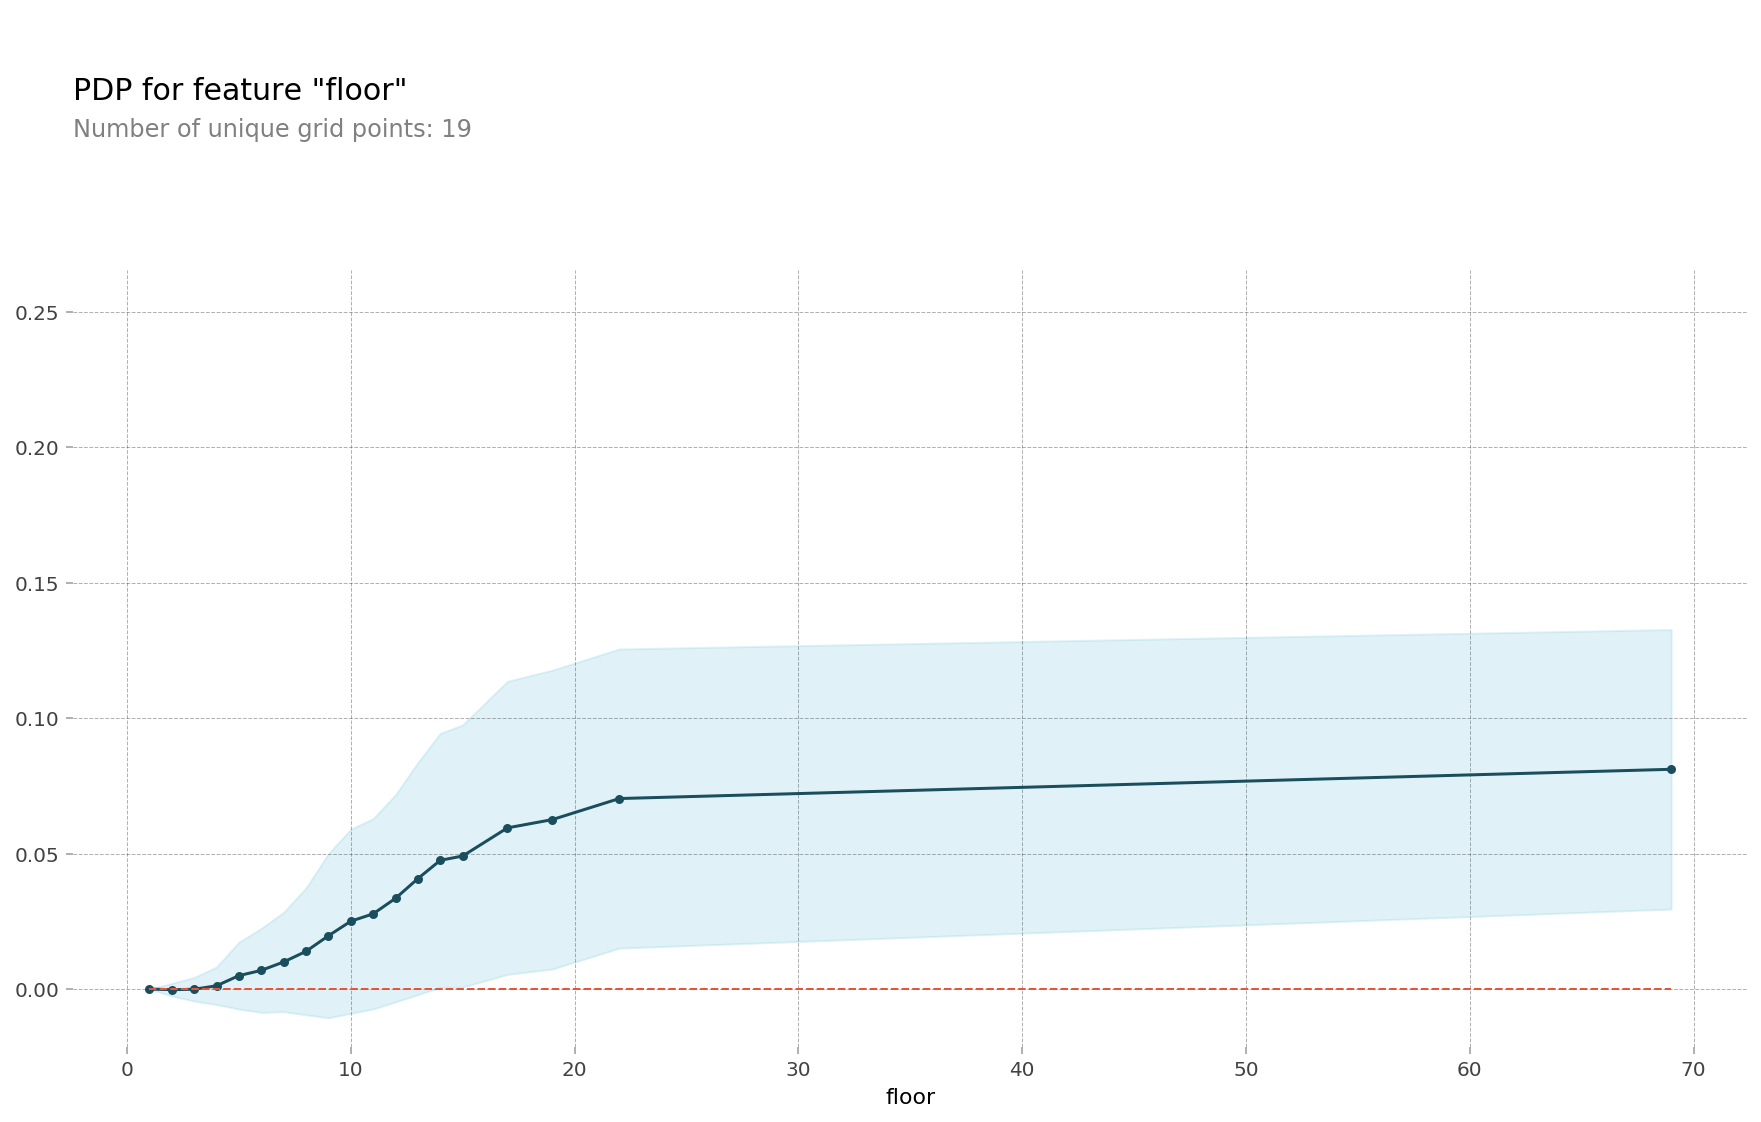

In [ ]:
# 1D PDP
features = ['size', 'years', 'floor']

for feature in features:
  isolated = pdp_isolate(
      model=final_model,
      dataset=X_total_transformed,
      model_features=feature_names,
      feature=feature,
      num_grid_points=30
  )
  pdp_plot(isolated, feature_name=feature);

In [ ]:
feature = 'size_grade'

pdp_dist = pdp.pdp_isolate(model=final_model, dataset=X_total_transformed, model_features=feature_names, feature=feature)

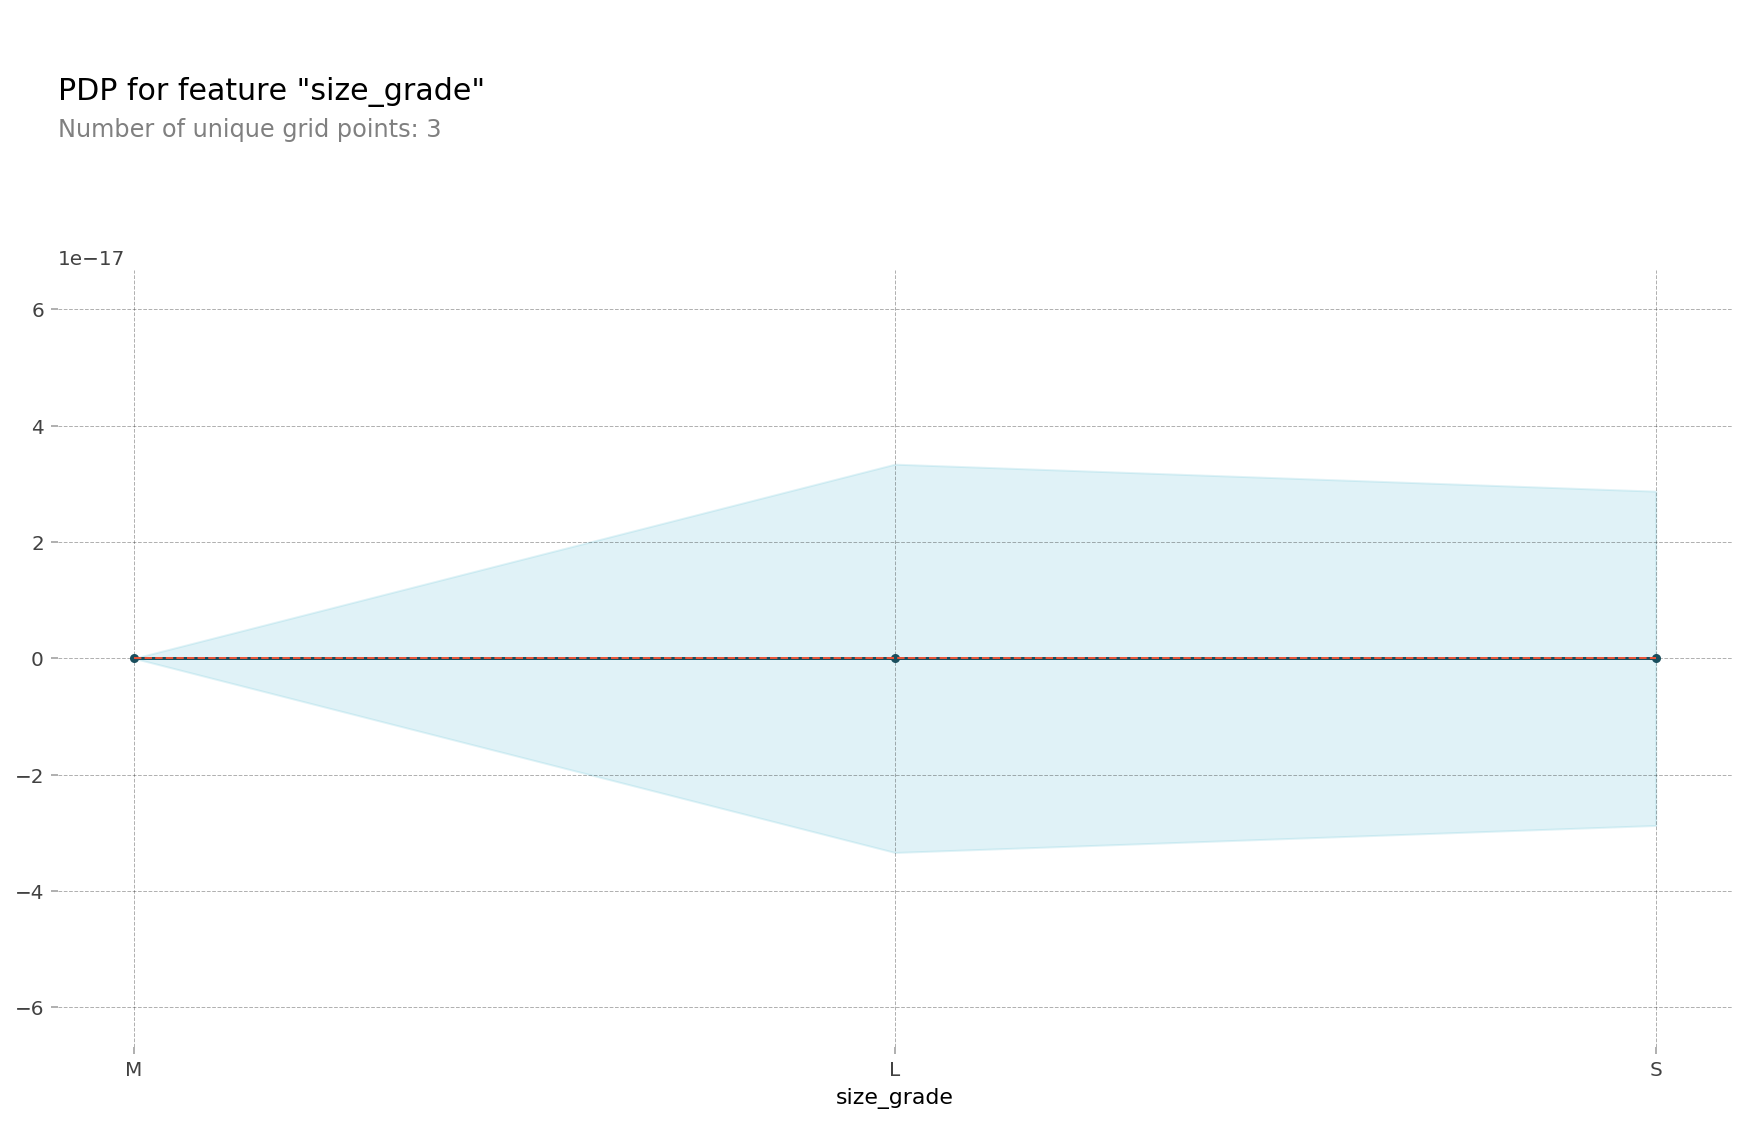

In [ ]:
pdp.pdp_plot(pdp_dist, feature);
plt.xticks([3, 1, 2], ['S', 'M', 'L']);

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


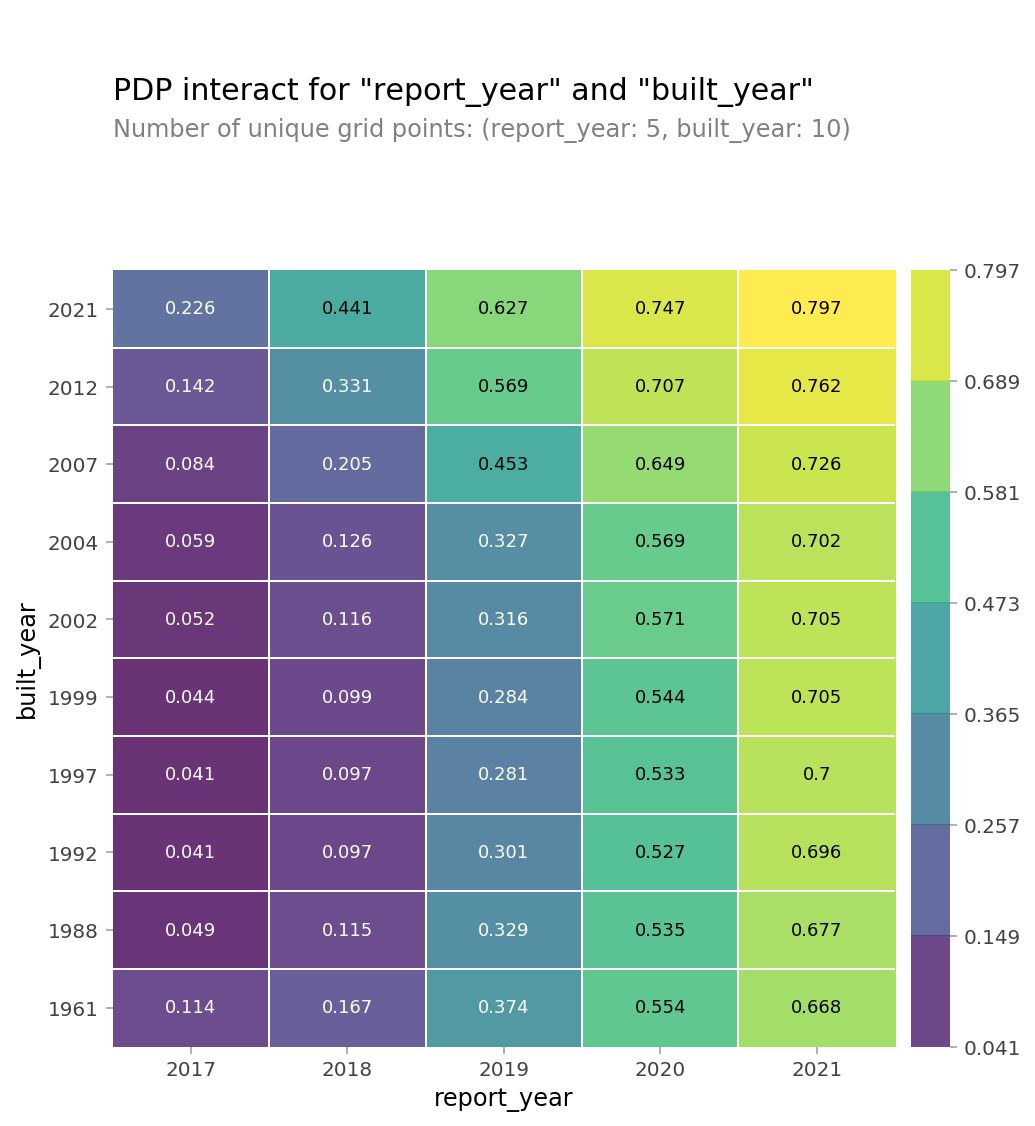

In [ ]:
# 2D PDP
features = ['report_year', 'built_year']

interaction = pdp_interact(
    model=final_model,
    dataset=X_total_transformed,
    model_features=X_total_transformed.columns,
    features=features
)

pdp_interact_plot(interaction, plot_type='grid', feature_names=features);

In [ ]:
X_total_transformed.groupby('report_year').size()

report_year
2017    97977
2018    85733
2019    64255
2020    83748
2021    36957
dtype: int64

In [ ]:
# Randomly sampling 0.1% of the data for each 'report_year'
report_years = np.arange(2017, 2022)
samples = pd.DataFrame([], columns=X_total_transformed.columns)

for rep_year in report_years:
  samples = samples.append(X_total_transformed[X_total_transformed.report_year == rep_year].sample(int(X_total_transformed.groupby('report_year').size()[rep_year]*0.001)), ignore_index=True)

samples.shape

(365, 8)

In [ ]:
# SHAP (classification model)
model = final_model.named_steps['randomforestclassifier']

explainer = shap.TreeExplainer(model)

shap_values = explainer.shap_values(samples)

In [ ]:
shap.initjs()
shap.force_plot(explainer.expected_value[0], shap_values[0], samples, link='logit')

# The more recent the 'report_year', the higher the likelihood of being a high-priced house.

# The likelihood of being a high-priced house increases for properties with a 'size' larger than approximately 84 square meters.

# The likelihood of being a high-priced house significantly increases for properties 'built_year' after 2007 compared to earlier years.

# For houses categorized as size_grade L(2), the likelihood of being a high-priced house is the highest.

# Properties with a age (years) of less than 10 years have a higher likelihood of being a high-priced house.
# Notably, properties with an age of around 30 years or more still have a significant likelihood of being high-priced houses.

# Looking at the floor information, the likelihood of being classified as a high-priced house increases significantly for properties with 10 floors or more.

In [ ]:
shap.initjs()
row = X_total_transformed.sample(1)
print(row.index)
shap_value = explainer.shap_values(row)
shap.force_plot(explainer.expected_value[0], shap_value[0], row, link='logit')

Int64Index([140802], dtype='int64')


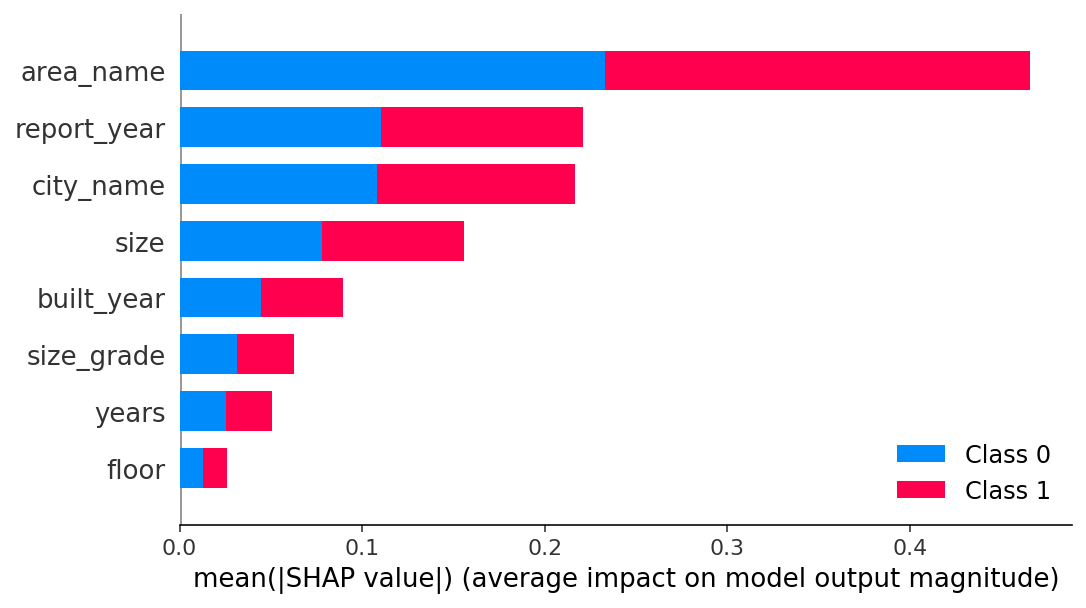

In [ ]:
shap.summary_plot(shap_values, X_total_transformed.sample(1000))

In [ ]:
def explain(row_number):
    positive_class = 1
    positive_class_index = 1

    row = X_total_transformed.iloc[[row_number]]

    # Make predictions and get prediction probabilities
    pred = model.predict(row)[0]
    pred_proba = model.predict_proba(row)[0, positive_class_index]
    pred_proba *= 100
    if pred != positive_class:
        pred_proba = 100 - pred_proba

    # Get the prediction result and probability
    print(f'고가주택 여부에 대한 예측결과는 {pred}, 확률은 {pred_proba:.0f}% 입니다.')

    # Add SHAP values
    shap_values = explainer.shap_values(row)

    # Get the top 3 pros and cons for Positive class
    feature_names = row.columns
    feature_values = row.values[0]
    shaps = pd.Series(shap_values[0][0], zip(feature_names, feature_values))
    pros = shaps.sort_values(ascending=False)[:3].index
    cons = shaps.sort_values(ascending=True)[:3].index

    # The top 3 factors that contribute the most to a positive impact
    print('\n')
    print('Positive 영향을 가장 많이 주는 3가지 요인 입니다:')

    evidence = pros if pred == positive_class else cons
    for i, info in enumerate(evidence, start=1):
        feature_name, feature_value = info
        print(f'{i}. {feature_name} : {feature_value}')

    # The top 3 factors that contribute the most to a negative impact
    print('\n')
    print('Negative 영향을 가장 많이 주는 3가지 요인 입니다:')

    evidence = cons if pred == positive_class else pros
    for i, info in enumerate(evidence, start=1):
        feature_name, feature_value = info
        print(f'{i}. {feature_name} : {feature_value}')

    # SHAP
    shap.initjs()
    return shap.force_plot(
        base_value=explainer.expected_value[0],
        shap_values=shap_values[0],
        features=row,
        link='logit'
    )

In [ ]:
# Comparison of Predicted Values vs. Actual Values
class_index = 1
y_pred_proba = model.predict_proba(X_total_transformed)[:, class_index]

df_p = pd.DataFrame({
    'pred_proba': y_pred_proba, # Predicted probability
    'is_high_price': y_total # Actual values
})

df_p = pd.concat([df_p, X_total], axis=1)

In [ ]:
df_p.head()

,pred_proba,is_high_price,city_name,area_name,report_year,size,floor,built_year,years,size_grade
0,0.806753,1,서초구,서초동,2017,84.98,6,2006,11,M
1,0.000000,0,강동구,성내동,2017,84.91,6,2002,15,M
2,0.002514,0,강동구,명일동,2017,84.76,5,2004,13,M
3,0.444342,1,강동구,둔촌동,2017,88.26,4,1980,37,L
4,0.000000,0,강동구,천호동,2017,83.15,13,1998,19,M


In [ ]:
is_high = df_p['is_high_price'] == 1
is_not_high = ~is_high

right = (is_high) == (df_p['pred_proba'] > 0.50)
wrong = ~right

In [ ]:
df_p[is_high & right].sample(n=10, random_state=1).sort_values(by='pred_proba')

,pred_proba,is_high_price,city_name,area_name,report_year,size,floor,built_year,years,size_grade
9417,0.531220,1,송파구,잠실동,2017,59.8800,5,2007,10,S
343353,0.554294,1,중랑구,묵동,2021,126.2800,1,1995,26,L
350659,0.764353,1,강서구,염창동,2021,84.9783,7,2019,2,M
309275,0.815529,1,송파구,가락동,2020,133.7600,8,1985,35,L
220730,0.847226,1,강남구,논현동,2019,84.9500,2,2002,17,M
336832,0.872792,1,동작구,흑석동,2021,124.9500,9,1988,33,L
346106,0.908384,1,송파구,장지동,2021,59.8500,9,2013,8,S
342988,0.974514,1,용산구,한강로3가,2021,84.7300,18,2006,15,M
310391,0.977550,1,송파구,잠실동,2020,59.9900,17,2008,12,S
356118,0.999267,1,강남구,도곡동,2021,128.7400,23,2004,17,L


In [ ]:
explain(9417)

고가주택 여부에 대한 예측결과는 1, 확률은 53% 입니다.


Positive 영향을 가장 많이 주는 3가지 요인 입니다:
1. report_year : 2017.0
2. size : 59.88
3. size_grade : 3.0


Negative 영향을 가장 많이 주는 3가지 요인 입니다:
1. area_name : 0.9205426356589147
2. built_year : 2007.0
3. years : 10.0


In [ ]:
df_p[is_not_high & right].sample(n=10, random_state=1).sort_values(by='pred_proba')

,pred_proba,is_high_price,city_name,area_name,report_year,size,floor,built_year,years,size_grade
71433,0.000404,0,구로구,고척동,2017,82.48,9,1985,32,M
72856,0.000957,0,구로구,오류동,2017,61.26,19,2004,13,M
51175,0.003607,0,양천구,신월동,2017,84.93,20,2003,14,M
290789,0.004021,0,강서구,방화동,2020,67.68,8,2003,17,M
241093,0.005577,0,관악구,신림동,2019,82.65,1,2008,11,M
313100,0.020046,0,노원구,상계동,2020,84.20,8,1987,33,M
118287,0.020229,0,강동구,명일동,2018,83.52,13,1985,33,M
368515,0.060503,0,노원구,공릉동,2021,84.00,2,2004,17,M
299428,0.078758,0,강서구,화곡동,2020,59.98,4,2008,12,S
2107,0.156069,0,강동구,고덕동,2017,59.35,20,2016,1,S


In [ ]:
explain(2107)

고가주택 여부에 대한 예측결과는 0, 확률은 84% 입니다.


Positive 영향을 가장 많이 주는 3가지 요인 입니다:
1. built_year : 2016.0
2. floor : 20.0
3. area_name : 0.342668863261944


Negative 영향을 가장 많이 주는 3가지 요인 입니다:
1. report_year : 2017.0
2. size : 59.35
3. city_name : 0.12727949385932266


In [ ]:
df_p[is_high & wrong].sample(n=10, random_state=1).sort_values(by='pred_proba')

,pred_proba,is_high_price,city_name,area_name,report_year,size,floor,built_year,years,size_grade
105187,0.013129,1,동대문구,답십리동,2018,84.99,11,2014,4,M
159175,0.085494,1,마포구,신공덕동,2018,84.90,8,2000,18,M
337960,0.091256,1,동작구,노량진동,2021,59.67,16,2001,20,S
224098,0.103692,1,영등포구,당산동,2019,108.15,15,2002,17,L
185361,0.125347,1,노원구,중계동,2019,115.26,7,1993,26,L
301875,0.128440,1,송파구,풍납동,2020,84.38,10,1995,25,M
314160,0.297914,1,노원구,중계동,2020,134.74,12,1993,27,L
301364,0.299047,1,광진구,광장동,2020,59.95,14,1996,24,S
10459,0.426120,1,송파구,석촌동,2017,134.43,12,2005,12,L
11463,0.460463,1,송파구,장지동,2017,87.69,6,2015,2,L


In [ ]:
explain(11463)

고가주택 여부에 대한 예측결과는 0, 확률은 54% 입니다.


Positive 영향을 가장 많이 주는 3가지 요인 입니다:
1. built_year : 2015.0
2. size_grade : 2.0
3. years : 2.0


Negative 영향을 가장 많이 주는 3가지 요인 입니다:
1. report_year : 2017.0
2. area_name : 0.23538622129436326
3. floor : 6.0


In [ ]:
df_p[is_not_high & wrong].sample(n=10, random_state=1).sort_values(by='pred_proba')

,pred_proba,is_high_price,city_name,area_name,report_year,size,floor,built_year,years,size_grade
266257,0.639314,0,송파구,방이동,2020,59.37,3,1996,24,S
247926,0.654966,0,동작구,동작동,2019,60.00,6,2013,6,S
21408,0.768660,0,용산구,신계동,2017,84.89,20,2011,6,M
350858,0.774576,0,강서구,화곡동,2021,84.97,11,2006,15,M
352403,0.835883,0,강서구,마곡동,2021,84.97,4,1999,22,M
284516,0.836706,0,강남구,삼성동,2020,58.78,11,1997,23,S
243315,0.861897,0,서초구,우면동,2019,84.96,1,1995,24,M
354837,0.916080,0,강남구,자곡동,2021,59.96,4,2014,7,S
43369,0.955097,0,서초구,방배동,2017,129.16,4,2006,11,L
181566,0.962464,0,서초구,서초동,2018,154.80,1,2004,14,L


In [ ]:
explain(266257)

고가주택 여부에 대한 예측결과는 1, 확률은 64% 입니다.


Positive 영향을 가장 많이 주는 3가지 요인 입니다:
1. size : 59.37
2. built_year : 1996.0
3. size_grade : 3.0


Negative 영향을 가장 많이 주는 3가지 요인 입니다:
1. area_name : 0.5949033391915641
2. report_year : 2020.0
3. city_name : 0.45300564596479576


## 6. Changes in the High-priced Housing Ratio After 2021

By randomly sampling data from the years 2017 to 2021 and changing the report year to 2022, 2023, ...,

what will happen to the ratio of high-priced homes?

In [ ]:
# Randomly sample 20% for each 'report_year'
report_years = np.arange(2017, 2022)
samples = pd.DataFrame([], columns=X_total.columns)

for rep_year in report_years:
  samples = samples.append(X_total[X_total.report_year == rep_year].sample(int(X_total.groupby('report_year').size()[rep_year]*0.2)), ignore_index=True)

samples.shape

(73732, 8)

In [ ]:
samples.head()

,city_name,area_name,report_year,size,floor,built_year,years,size_grade
0,강남구,일원동,2017,134.44,8,1994,23,L
1,강남구,청담동,2017,149.74,4,2010,7,L
2,강동구,암사동,2017,59.52,8,1998,19,S
3,마포구,성산동,2017,59.43,5,1986,31,S
4,중구,신당동,2017,84.88,2,2002,15,M


In [ ]:
columns=['not high', 'high']
ratio_flow = pd.DataFrame([])

for report_year in report_years:
  tmp = df_p[df_p.report_year == report_year]
  ratio_flow = ratio_flow.append(pd.DataFrame(tmp.is_high_price.value_counts(normalize=True)).T.rename(index={'is_high_price':report_year}))

In [ ]:
ratio_flow

,0,1
2017,0.865999,0.134001
2018,0.836131,0.163869
2019,0.722839,0.277161
2020,0.706142,0.293858
2021,0.572422,0.427578


In [ ]:
sample_future = samples.copy()
future_years = np.arange(2022, 2030)
ratio_flow_future = pd.DataFrame([])

for future_year in future_years:
  sample_future.report_year = future_year
  sample_future.years = sample_future.report_year - sample_future.built_year

  y_pred_future = final_model.predict(sample_future)

  ratio_flow_future = ratio_flow_future.append(pd.DataFrame(pd.Series(y_pred_future, name=future_year).value_counts(normalize=True)).T)

In [ ]:
ratio_flow_future

,1,0
2022,0.603849,0.396151
2023,0.603619,0.396381
2024,0.602710,0.397290
2025,0.602791,0.397209
2026,0.602683,0.397317
2027,0.603252,0.396748
2028,0.602371,0.397629
2029,0.602710,0.397290


In [ ]:
ratio_flow_future = ratio_flow_future[[0, 1]]
ratio_flow_future

,0,1
2022,0.396151,0.603849
2023,0.396381,0.603619
2024,0.397290,0.602710
2025,0.397209,0.602791
2026,0.397317,0.602683
2027,0.396748,0.603252
2028,0.397629,0.602371
2029,0.397290,0.602710


In [ ]:
ratio_flow = ratio_flow.append(ratio_flow_future)
ratio_flow = ratio_flow.rename(columns={0:'not high', 1:'high'})
ratio_flow

,not high,high
2017,0.865999,0.134001
2018,0.836131,0.163869
2019,0.722839,0.277161
2020,0.706142,0.293858
2021,0.572422,0.427578
2022,0.396151,0.603849
2023,0.396381,0.603619
2024,0.397290,0.602710
2025,0.397209,0.602791
2026,0.397317,0.602683


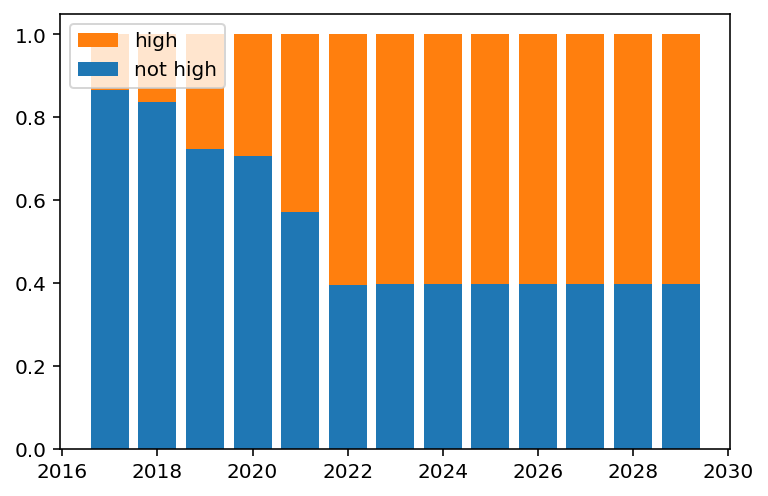

In [ ]:
ind = ratio_flow.index

p1 = plt.bar(ind, ratio_flow['not high'])
p2 = plt.bar(ind, ratio_flow['high'], bottom=ratio_flow['not high'].tolist())

plt.legend((p2[0], p1[0]), ('high', 'not high'))
plt.show();
# Due to the limitations of feature engineering, the change in the ratio of high-priced homes after 2022 is extremely minimal.
# However, there is a high probability that the ratio of high-priced homes will continue to increase.